### Set variables

In [1]:
## Year of period split
anno = "2016"
## How much months casuality analysis looks back
TAU_MAX = 12


### Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FormatStrFormatter



### Load and visualize data

In [3]:

data = pd.read_csv('data.csv', header=0, parse_dates=[0], sep=',')
data.columns = data.columns.str.strip()
data.rename(columns={'CO2_Con':'CO2'}, inplace=True)
data['Datetime'] = pd.to_datetime(data["date"])
data = data[["Datetime","O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]]
data

,Datetime,O2,CO2,Temperature,Salinity,pH,EC50
0,2003-01-01,244.25089,33.043930,13.899383,37.763194,8.155155,NaN
1,2003-02-01,252.53078,30.830639,12.228910,37.792016,8.181169,28.97
2,2003-03-01,254.69466,31.928104,13.029431,37.878502,8.168952,39.77
3,2003-04-01,254.88481,33.393970,14.144464,37.888187,8.152712,55.44
4,2003-05-01,249.18790,39.920483,18.658495,37.799844,8.087382,24.15
...,...,...,...,...,...,...,...
232,2022-05-01,247.31284,43.736410,18.932010,38.191498,8.055904,NaN
233,2022-06-01,230.25885,53.264680,24.568462,38.182266,7.983217,NaN
234,2022-07-01,222.63089,58.078090,27.196798,38.172510,7.951786,NaN
235,2022-08-01,221.80557,56.470406,26.143705,38.213444,7.961412,NaN


Fill missing values of EC50 by rolling mean.

In [4]:
data["EC50"] =  data["EC50"].rolling(min_periods=1, center=True, window=12).mean()
df = data.dropna()

### PCA anomaly detection

In [5]:
X = df[[ "O2", "CO2", "Temperature", "Salinity", "pH","EC50"]]
### PCA ANOMALY DETECTION ###
rec_errors_samples = {}
rec_errors_features = {}
for i, (past_id,future_id) in enumerate(
    TimeSeriesSplit(20, test_size=11).split(X)
):
    scaler = StandardScaler()
    pca = PCA(0.7)
    pca.fit(scaler.fit_transform(X.iloc[past_id]))  
    Xt = pca.inverse_transform(
        pca.transform(
            scaler.transform(X.iloc[future_id])
        )
    )
    rec_errors_samples[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=1)
    rec_errors_features[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=0)

### Decompose and plot data

In [6]:
def decompose(df, data_colum_name):
    data_decompose = df.set_index("Datetime")
    decompose_result_mult = seasonal_decompose(data_decompose[data_colum_name], model="multiplicative",extrapolate_trend='freq',period=12,two_sided=False)
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid
    res=decompose_result_mult
    #res.plot()
    trend.to_csv("trend_" + data_colum_name + ".csv")
    return res, seasonal, trend, residual 

In [7]:
ec50, seasonal_ec50, trend_ec50, residual_ec50 = decompose(df, "EC50")
temperature, seasonal_temperature, trend_temperature, residual_temperature = decompose(df, "Temperature")
ph, seasonal_pH, trend_pH, residual_pH = decompose(df, "pH")
salinity, seasonal_salinity, trend_salinity, residual_salinity = decompose(df, "Salinity")
o2, seasonal_o2, trend_o2, residual_o2 = decompose(df, "O2")
co2, seasonal_co2, trend_co2, residual_co2 = decompose(df, "CO2")

df_trend = df.copy()
df_trend["EC50"] = trend_ec50.values
df_trend["Temperature"] = trend_temperature.values
df_trend["pH"] = trend_pH.values
df_trend["Salinity"] = trend_salinity.values
df_trend["O2"] = trend_o2.values
df_trend["CO2"] = trend_co2.values


In [8]:
df_pre =  df[(df['Datetime'] < anno + "-01-01")]
df_post =  df[(df['Datetime'] >= anno + "-01-01")]

ec50_pre, seasonal_ec50_pre, trend_ec50_pre, residual_ec50_pre = decompose(df_pre, "EC50")
temperature_pre, seasonal_temperature_pre, trend_temperature_pre, residual_temperature_pre = decompose(df_pre, "Temperature")
ph_pre, seasonal_pH_pre, trend_pH_pre, residual_pH_pre = decompose(df_pre, "pH")
salinity_pre, seasonal_salinity_pre, trend_salinity_pre, residual_salinity_pre = decompose(df_pre, "Salinity")
o2_pre, seasonal_o2_pre, trend_o2_pre, residual_o2_pre = decompose(df_pre, "O2")
co2_pre, seasonal_co2_pre, trend_co2_pre, residual_co2_pre = decompose(df_pre, "CO2")

trend_df_pre = df_pre[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df_pre["EC50"] = trend_ec50_pre.to_frame().dropna().values
trend_df_pre["O2"] = trend_o2_pre.to_frame().dropna().values
trend_df_pre["CO2"] = trend_co2_pre.to_frame().dropna().values
trend_df_pre["Temperature"] = trend_temperature_pre.to_frame().dropna().values
trend_df_pre["Salinity"] = trend_salinity_pre.to_frame().dropna().values
trend_df_pre["pH"] = trend_pH_pre.to_frame().dropna().values

ec50_post, seasonal_ec50_post, trend_ec50_post, residual_ec50_post = decompose(df_post, "EC50")
temperature_post, seasonal_temperature_post, trend_temperature_post, residual_temperature_post = decompose(df_post, "Temperature")
ph_post, seasonal_pH_post, trend_pH_post, residual_pH_post = decompose(df_post, "pH")
salinity_post, seasonal_salinity_post, trend_salinity_post, residual_salinity_post = decompose(df_post, "Salinity")
o2_post, seasonal_o2_post, trend_o2_post, residual_o2_post = decompose(df_post, "O2")
co2_post, seasonal_co2_post, trend_co2_post, residual_co2_post = decompose(df_post, "CO2")


trend_df_post = df_post[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df_post["EC50"] = trend_ec50_post.to_frame().dropna().values
trend_df_post["O2"] = trend_o2_post.to_frame().dropna().values
trend_df_post["CO2"] = trend_co2_post.to_frame().dropna().values
trend_df_post["Temperature"] = trend_temperature_post.to_frame().dropna().values
trend_df_post["Salinity"] = trend_salinity_post.to_frame().dropna().values
trend_df_post["pH"] = trend_pH_post.to_frame().dropna().values


Temperature2003-2022 S:5.000209979992878e-05 I:    <2016 S:-1.0352591164280084e-05  - I:   >=2016 S:0.00022933807033885046
Salinity2003-2022 S:2.971129753407759e-05 I:    <2016 S:-8.063835246369512e-06  - I:   >=2016 S:1.9200192605092498e-05
pH2003-2022 S:-3.212400103011905e-06 I:    <2016 S:-2.678549282452385e-07  - I:   >=2016 S:-1.3880295630349163e-05
$O_{2}$2003-2022 S:-0.00017505420198396472 I:    <2016 S:0.00012713522130422105  - I:   >=2016 S:-0.0030613454499755733
$CO_{2}$2003-2022 S:0.0003516702559631684 I:    <2016 S:-1.1671179518476463e-05  - I:   >=2016 S:0.001549811868944639
$EC_{50}$2003-2022 S:-0.0029649707772495576 I:    <2016 S:0.0012651809968117578  - I:   >=2016 S:-0.0072796709446532985


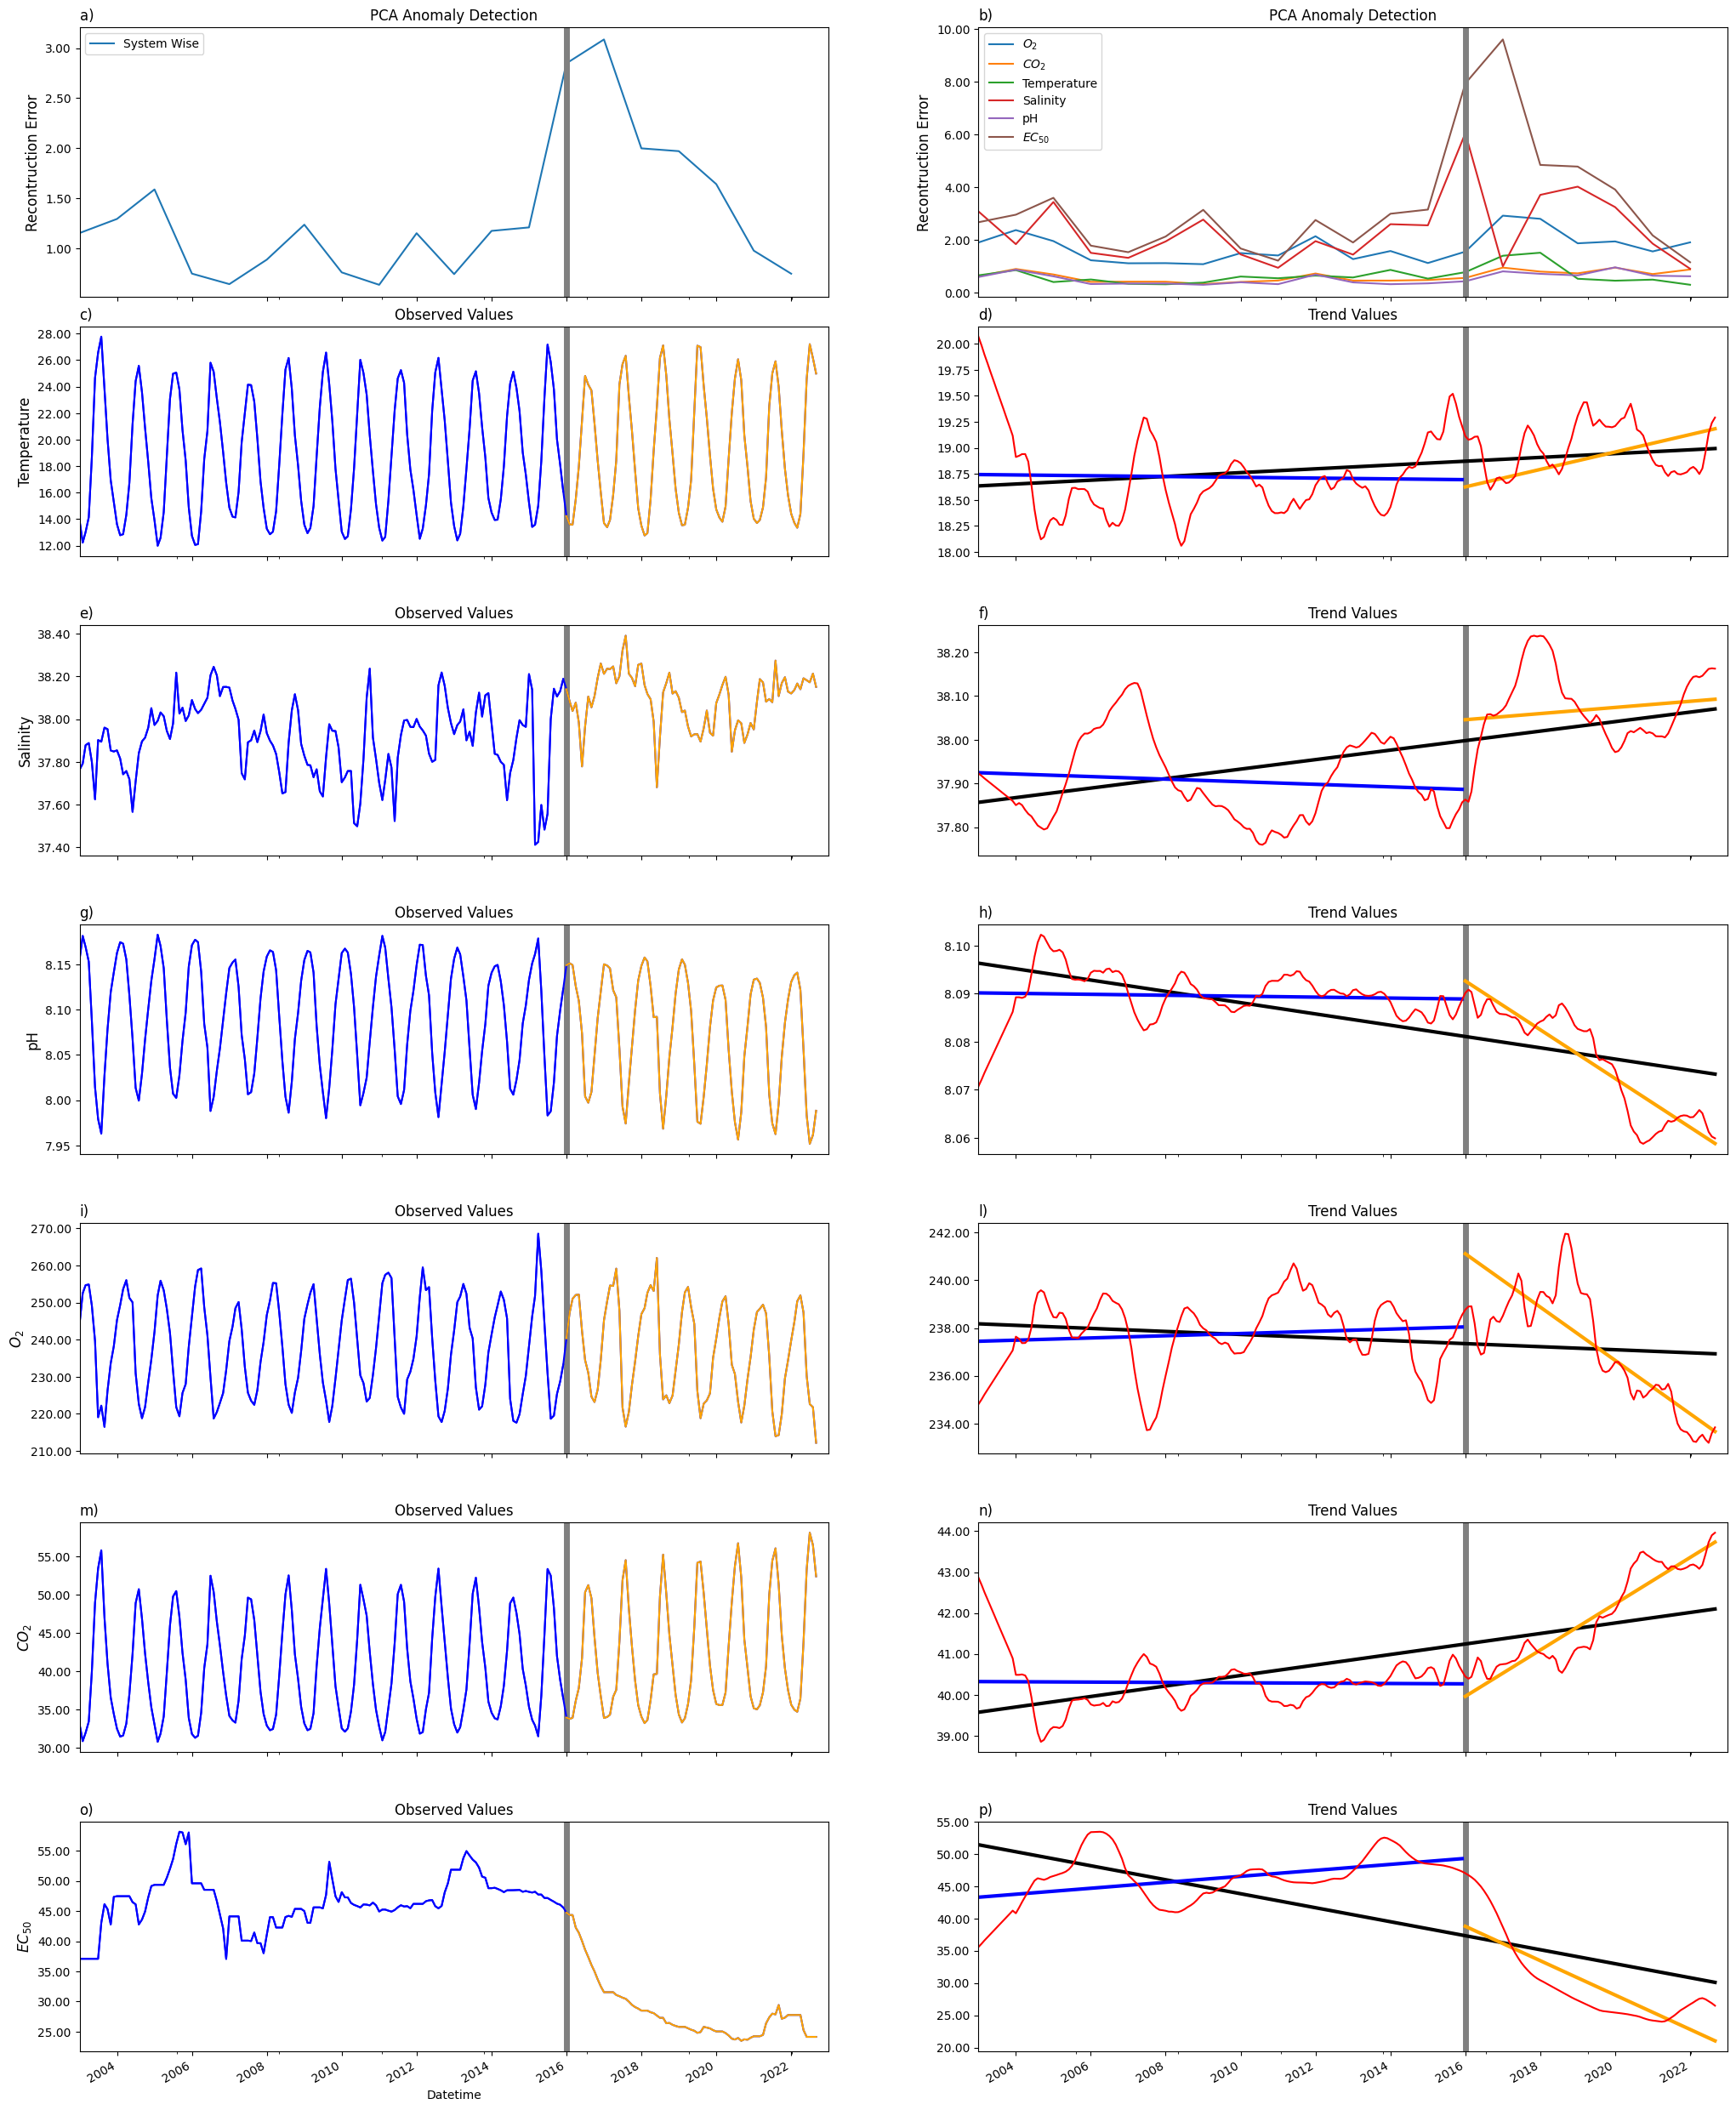

In [9]:
res2 = np.arange(np.datetime64("2003-01-01"), np.datetime64("2022-12-01"),  np.timedelta64(1, 'Y'),  dtype='datetime64[M]')
res3 = np.arange(np.datetime64("2003-01-01"), np.datetime64("2022-12-01"),  np.timedelta64(1, 'Y'),  dtype='datetime64[Y]')

def plotseasonal(res,res_pre, res_post, x1, x2, label , slopes, titoli, etichetta=False):
    x1.set_ylabel(label , size='large')
    x1.set_title("Observed Values", size='large', loc='center')
    x2.set_title("Trend Values", size='large', loc='center')
    x1.set_title(titoli[0], size='large', loc='left')
    x2.set_title(titoli[1], size='large', loc='left')
    x1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    x2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    temp = res.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope = str(reg.params[1])
    intercept = str(round(reg.params[0],5)) 
    x1.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
    x2.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
    res.observed.plot(ax=x1,  legend=False, color='blue')
    x2.plot(xx,y_predicted, color='black',linewidth=3)
    temp = res_pre.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope_pre =  str(reg.params[1])
    intercept_pre = str(round(reg.params[0],5)) 
    res_pre.observed.plot(ax=x1, sharex=x1, legend=False, color='blue')
    x2.plot(xx,y_predicted, color='blue',linewidth=3)
    temp = res_post.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope_post = str(reg.params[1])
    intercept_post = str(round(reg.params[0],5)) 
    res_post.observed.plot(ax=x1, legend=False, color='orange')
    x2.plot(xx,y_predicted, color='orange',linewidth=3) 
    slopes = label + "2003-2022 S:" +  slope + " I:" + "    <" + anno +" S:" +  slope_pre + "  - I:" + "   >=" + anno +" S:" +  slope_post 
    print(slopes)
    res.trend.plot(ax=x2, legend=False, color='red')
    x2.axis(xmin=np.datetime64("2003-01-01"), xmax = np.datetime64("2023-01-01"))
    if etichetta:
        x2.set_xlabel("") 
    else :
        x1.set_xlabel("")
        x2.set_xlabel("")   

fig, axes = plt.subplots(ncols=2, nrows=7, sharex=True, sharey=False, figsize=(25,35))
plt.subplots_adjust(hspace = 0.3)
slopes = ""
cols = ["$O_{2}$","$CO_{2}$", "Temperature","Salinity", "pH", "$EC_{50}$"]
rows = ["Measures","Trend","Seasonality"]
n_features = len(cols)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
rec =   [np.mean(r) for r in rec_errors_samples.values()]
ff = plt.subplot(6,2,1)
plt.plot(res2,rec,label="System Wise")
ff.set_title("PCA Anomaly Detection", size='large', loc='center')
ff.set_title("a)", size='large', loc='left')
plt.ylabel('Recontruction Error', size='large'); 
plt.legend(loc="upper left")
ff.set_xlabel("")
ff.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ff.axvline(x=np.datetime64("2016-01-01"), color='gray', linewidth=5)
plt.xlim(np.datetime64("2003-01-01"), np.datetime64("2023-01-01"))
ff = plt.subplot(6,2,2)
for i in range(n_features):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(res2,rec,label=cols[i])
plt.ylabel('Recontruction Error', size='large');
ff.set_title("PCA Anomaly Detection", size='large', loc='center')
ff.set_title("b)", size='large', loc='left')
ff.set_xlabel("")
ff.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ff.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
plt.legend(loc="upper left")
plt.xlim(np.datetime64("2003-01-01"), np.datetime64("2023-01-01"))

plotseasonal(temperature, temperature_pre, temperature_post, axes[1,0], axes[1,1], "Temperature",slopes, titoli=["c)","d)"], etichetta=False )
plotseasonal(salinity, salinity_pre, salinity_post, axes[2,0], axes[2,1],"Salinity",slopes, titoli=["e)","f)"], etichetta=False, )
plotseasonal(ph, ph_pre, ph_post, axes[3,0], axes[3,1],"pH",slopes, titoli=["g)","h)"], etichetta=False)
plotseasonal(o2, o2_pre, o2_post, axes[4,0], axes[4,1],"$O_{2}$",slopes, titoli=["i)","l)"], etichetta=False)
plotseasonal(co2, co2_pre, co2_post, axes[5,0], axes[5,1], "$CO_{2}$",slopes, titoli=["m)","n)"], etichetta=False)
plotseasonal(ec50, ec50_pre, ec50_post, axes[6,0], axes[6,1], "$EC_{50}$",slopes, titoli=["o)","p)"], etichetta=True)

plt.show()
fig.savefig("plots-" + anno + ".pdf")

### Period split

We can perform Kruskal-Wallis and Mann-Whitneyu for EC50 values before and after 01-01-2016.

In [10]:
stats.kruskal(df_pre["EC50"],df_post["EC50"] )

KruskalResult(statistic=150.7374237488993, pvalue=1.1961316983628424e-34)

In [11]:
stats.mannwhitneyu(df_pre["EC50"],df_post["EC50"])

MannwhitneyuResult(statistic=12464.0, pvalue=1.2109868782577416e-34)

As pvalue is much greater than 0.05 we can refuse the null iphothesis that the medians of the two different periods are equal.

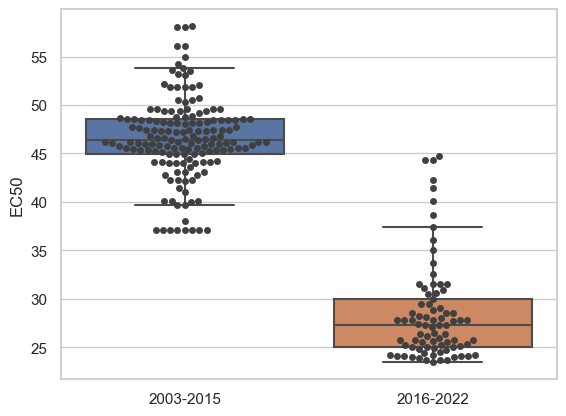

In [12]:
sns.set(style="whitegrid")
df["2016-2022"] = (df['Datetime'] >= anno + "-01-01")
fig = plt.figure()
ax = sns.boxplot(x="2016-2022", y="EC50", data=df, showfliers = False)
ax = sns.swarmplot(x="2016-2022", y="EC50", data=df, color=".25")
plt.xticks([0, 1], ['2003-2015', '2016-2022'])
ax.set_xlabel('')

plt.show()

### Correlation analysis

Test for if trends are normal distributed.

In [13]:
print("EC50 - " + str(shapiro(trend_ec50)))
print("O2 - " + str(shapiro(trend_o2)))
print("CO2 - " + str(shapiro(trend_co2)))
print("Temperature - " + str(shapiro(trend_temperature)))
print("Salinity - " + str(shapiro(trend_salinity)))
print("pH - " + str(shapiro(trend_pH)))

EC50 - ShapiroResult(statistic=0.8668988943099976, pvalue=1.6791276214508238e-13)
O2 - ShapiroResult(statistic=0.9687227010726929, pvalue=4.4526823330670595e-05)
CO2 - ShapiroResult(statistic=0.875939667224884, pvalue=5.556552397020798e-13)
Temperature - ShapiroResult(statistic=0.9771444201469421, pvalue=0.0007096421322785318)
Salinity - ShapiroResult(statistic=0.9620153307914734, pvalue=6.227187896001851e-06)
pH - ShapiroResult(statistic=0.8612942695617676, pvalue=8.223283843146814e-14)


They are not normal distributed. We have to use Spearman's algorithm to estimate the correlations between them.

In [14]:
trend_df = data[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df["EC50"] = trend_ec50.to_frame().dropna().values
trend_df["O2"] = trend_o2.to_frame().dropna().values
trend_df["CO2"] = trend_co2.to_frame().dropna().values
trend_df["Temperature"] = trend_temperature.to_frame().dropna().values
trend_df["Salinity"] = trend_salinity.to_frame().dropna().values
trend_df["pH"] = trend_pH.to_frame().dropna().values

In [15]:
def my_heat(corr, ax1) :
    axes = sns.heatmap(  corr, vmin=-1, 
                            #mask=mask,
                            vmax=1, 
                            #annot=annot,
                            linewidths=2, linecolor='black',
                            square=True, #linewidths=.5,
                            cbar_kws={"shrink": .5},
                            annot=True, 
                            annot_kws={ "size": 12, 
                                        #"color":"black", 
                                        "weight":"bold"},
                            #shapesize=pval,
                            cmap='bwr',
                            rasterized=True,
                            ax=ax1)

def display_correlation(df, label):
    corr = df.corr(method="spearman")
    pval = df.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*corr.shape) 
    mask = np.triu(np.ones_like(corr, dtype=bool),  k=0)
    mask |= pval >= 0.05
    corr = corr[~mask]  # fill in NaN in the non-desired cells
    remove_empty_rows_and_cols = False
    if remove_empty_rows_and_cols:
        wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
        wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
        corr = corr.iloc[wanted_cols, wanted_rows]
    fig, ax = plt.subplots()
    heatmap = my_heat(corr,ax)
    plt.close()
    return(corr,pval)

def display_corr_pairs(df,label,color="cyan"):
    from decimal import Decimal
    s = set_title = np.vectorize(lambda ax,r,rho: ax.title.set_text("r = " + 
                                        "{:.2f}".format(r) + 
                                        '\n $\\rho$ = ' + 
                                        '%.2E' % Decimal(rho)
                                        )
                                        if ax!=None else None
                            )      

    r,pval= display_correlation(df,label)
    return(r)

heat_map_all = display_corr_pairs(trend_df, "ALL DATA")
heat_map_post = display_corr_pairs(trend_df_post, "POST " + anno)
heat_map_pre = display_corr_pairs(trend_df_pre, "PRE " + anno)

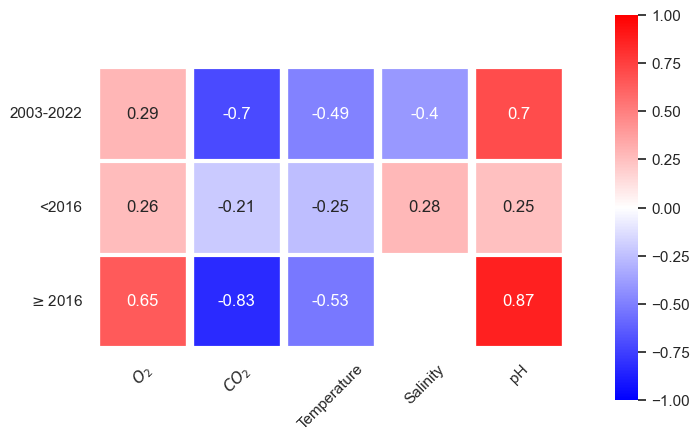

In [16]:
cols = ["$O_{2}$","$CO_{2}$", "Temperature","Salinity", "pH",  "$EC_{50}$"]
ycol= ["$EC_{50}$ Correlation"]
f,(ax1, axcb) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1,0.05]},
             figsize=(7,5))
temp =heat_map_all.loc['EC50',:]
#display(temp) 
temp_pre =heat_map_pre.loc['EC50',:]
temp_post =heat_map_post.loc['EC50',:]
ycol_all= ["2003-2022","<" + anno,"$\geq$" + anno ]
temp2 = np.vstack((temp,temp_pre,temp_post))
g3 = sns.heatmap( temp2, vmin=-1, 
                            #mask=mask,
                            vmax=1, 
                            #annot=annot,
                            xticklabels=cols, yticklabels=ycol_all,
                            linewidths=2, linecolor='black',
                            square=True, 
                            annot=True, 
                            cmap='bwr',
                            rasterized=True,
                            ax=ax1,
                            cbar_ax=axcb)
for i in range(temp2.shape[0] + 1):
    g3.axhline(i, color='white', lw=3)
for i in range(temp2.shape[1] + 1):
    g3.axvline(i, color='white', lw=6)
for ax in [g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=45)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    ax.set_xlim(0,5)
plt.show()
f.savefig("heatmaps-" + anno + ".pdf")



heat_map_all = display_corr_pairs(trend_df, "ALL DATA")

### Causality analysis

#### Stationarity

To indagate causality we should work with stationary time series, so we test data.

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pmd
# Stationarity
ALPHA = 0.05                
# We apply the ADF and KPSS tests of statsmodels.stattools:
# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable
# get results as a dictionary
def ADF_statt(x):
     adf_test = adfuller(x, autolag="aic")
     t_stat, p_value, _, _, _, _  = adf_test
     conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
     res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
     return res_dict

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable
# get results as a dictionary
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values  = kpss_test
     conclusion = "stationary" if p_value > ALPHA else "not stationary"
     res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
     return res_dict

def test_stationary(data, variable) :
    # call the KPSS test:
    resKPSS = KPSS_statt(data[variable])
    print("---------" + variable + "----------------")
    # print dictionary of test results:
    print("KPSS test result for " + variable + " original data:")
    for key,value in (resKPSS.items()) :
        if key == "conclusion": print(key, ":", value) 

import warnings
warnings.simplefilter("ignore")

# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
test_stationary(df, "EC50")
test_stationary(df, "Temperature")
test_stationary(df, "pH")
test_stationary(df, "Salinity")
test_stationary(df, "CO2")
test_stationary(df, "O2")

---------EC50----------------
KPSS test result for EC50 original data:
conclusion : not stationary
---------Temperature----------------
KPSS test result for Temperature original data:
conclusion : stationary
---------pH----------------
KPSS test result for pH original data:
conclusion : stationary
---------Salinity----------------
KPSS test result for Salinity original data:
conclusion : not stationary
---------CO2----------------
KPSS test result for CO2 original data:
conclusion : stationary
---------O2----------------
KPSS test result for O2 original data:
conclusion : stationary


We need to differenciate EC50 and Salinity.

In [18]:
df["EC50_diff"] = df["EC50"].diff().dropna()
df["Salinity_diff"] = df["Salinity"].diff().dropna()

df_pre["EC50_diff"] = df_pre["EC50"].diff().dropna()
df_pre["Salinity_diff"] = df_pre["Salinity"].diff().dropna()
df_post["EC50_diff"] = df_post["EC50"].diff().dropna()
df_post["Salinity_diff"] = df_post["Salinity"].diff().dropna()

#### 

#### CMIknn

In [19]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
import networkx as nx

PC_ALPHA = 0.05
ALPHA_LEVEL = PC_ALPHA 
KNN = 0.1
#TAU_MAX = 1 ##quando indietro cerco
VERBOSITY = 1#0

var_names = ["Temperature", "Salinity", "pH", "O2", "CO2", "EC50"]

df["EC50"] =  df["EC50_diff"].dropna()
df["Salinity"] =  df["Salinity_diff"].dropna()
df_pre["EC50"] =  df_pre["EC50_diff"].dropna()
df_pre["Salinity"] =  df_pre["Salinity_diff"].dropna()
df_post["EC50"] =  df_post["EC50_diff"].dropna()
df_post["Salinity"] =  df_post["Salinity_diff"].dropna()
df = df[["Temperature", "Salinity", "pH", "O2", "CO2", "EC50"]]
df_pre = df_pre[["Temperature", "Salinity", "pH", "O2", "CO2", "EC50"]]
df_post = df_post[["Temperature", "Salinity", "pH", "O2", "CO2", "EC50"]]
series_values =  df.values
mask = np.any(np.isnan(series_values), axis=1)
dataframe = pp.DataFrame(series_values[~mask], 
                         datatime = {0:np.arange(len(df))}, 
                         var_names=var_names)

We mute spurious causality from EC50.

In [20]:

def mute_spurious(graph) :
    empty = ["","","","","","","","","","","","","" ]
    for i in range(6):
        graph[i] =  [ empty, empty, empty,empty,empty,[w.replace('o-o', '') for w in graph[i][5]]]
    return graph

##### 2016-2022

In [21]:
series_values =  df_post.values
mask = np.any(np.isnan(series_values), axis=1)
dataframe = pp.DataFrame(series_values[~mask], 
                         datatime = {0:np.arange(len(df))}, 
                         var_names=var_names)
cmi_knn = CMIknn(significance='shuffle_test', knn=KNN, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=VERBOSITY)
results_post = pcmci_cmi_knn.run_pcmci(tau_max=TAU_MAX, pc_alpha=PC_ALPHA, alpha_level = ALPHA_LEVEL)
pcmci_cmi_knn.print_significant_links(
        p_matrix = results_post['p_matrix'], 
        val_matrix = results_post['val_matrix'],
        alpha_level = ALPHA_LEVEL)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 12
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Temperature has 2 link(s):
        (Temperature -12): max_pval = 0.04100, min_val =  0.326
        (pH -1): max_pval = 0.03200, min_val =  0.181

    Variable Salinity has 0 link(s):

    Variable pH has 0 link(s):

    Variable O2 has 0 link(s):

    Variable CO2 has 1 link(s):
        (EC50 -5): max_pval = 0.01700, min_val =  0.134

    Variable EC50 has 0 link(s):

##
## Step 2: MCI algorithm
##

Parameters:

independence test = cmi_knn
tau_min = 0
tau_max = 12
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable Temperature has 13 link(s):
        (O2 -7): pval = 0.00000 | val =  0.236
        (pH  0): pval = 0.00800 | val =  0.226 | unoriented link
        (pH -5): pval = 0.00100 | val =  0.218
        (pH -

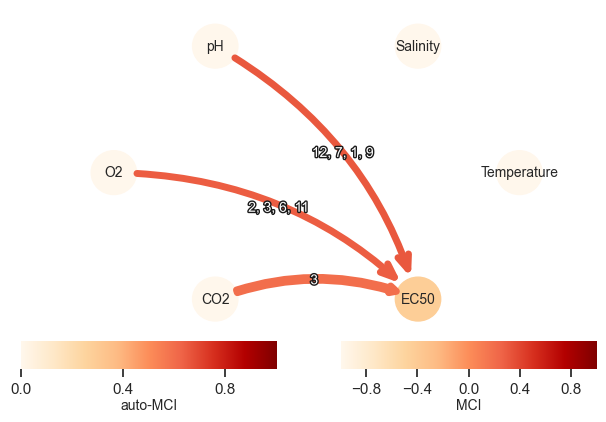

In [23]:
graph = results_post['graph'].copy()
f = tp.plot_graph(
    val_matrix=results_post['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    cmap_edges='OrRd',
    save_name = "causality-" + str(TAU_MAX) + "-" + str(KNN) + "-post" + anno + ".pdf",
    ); 

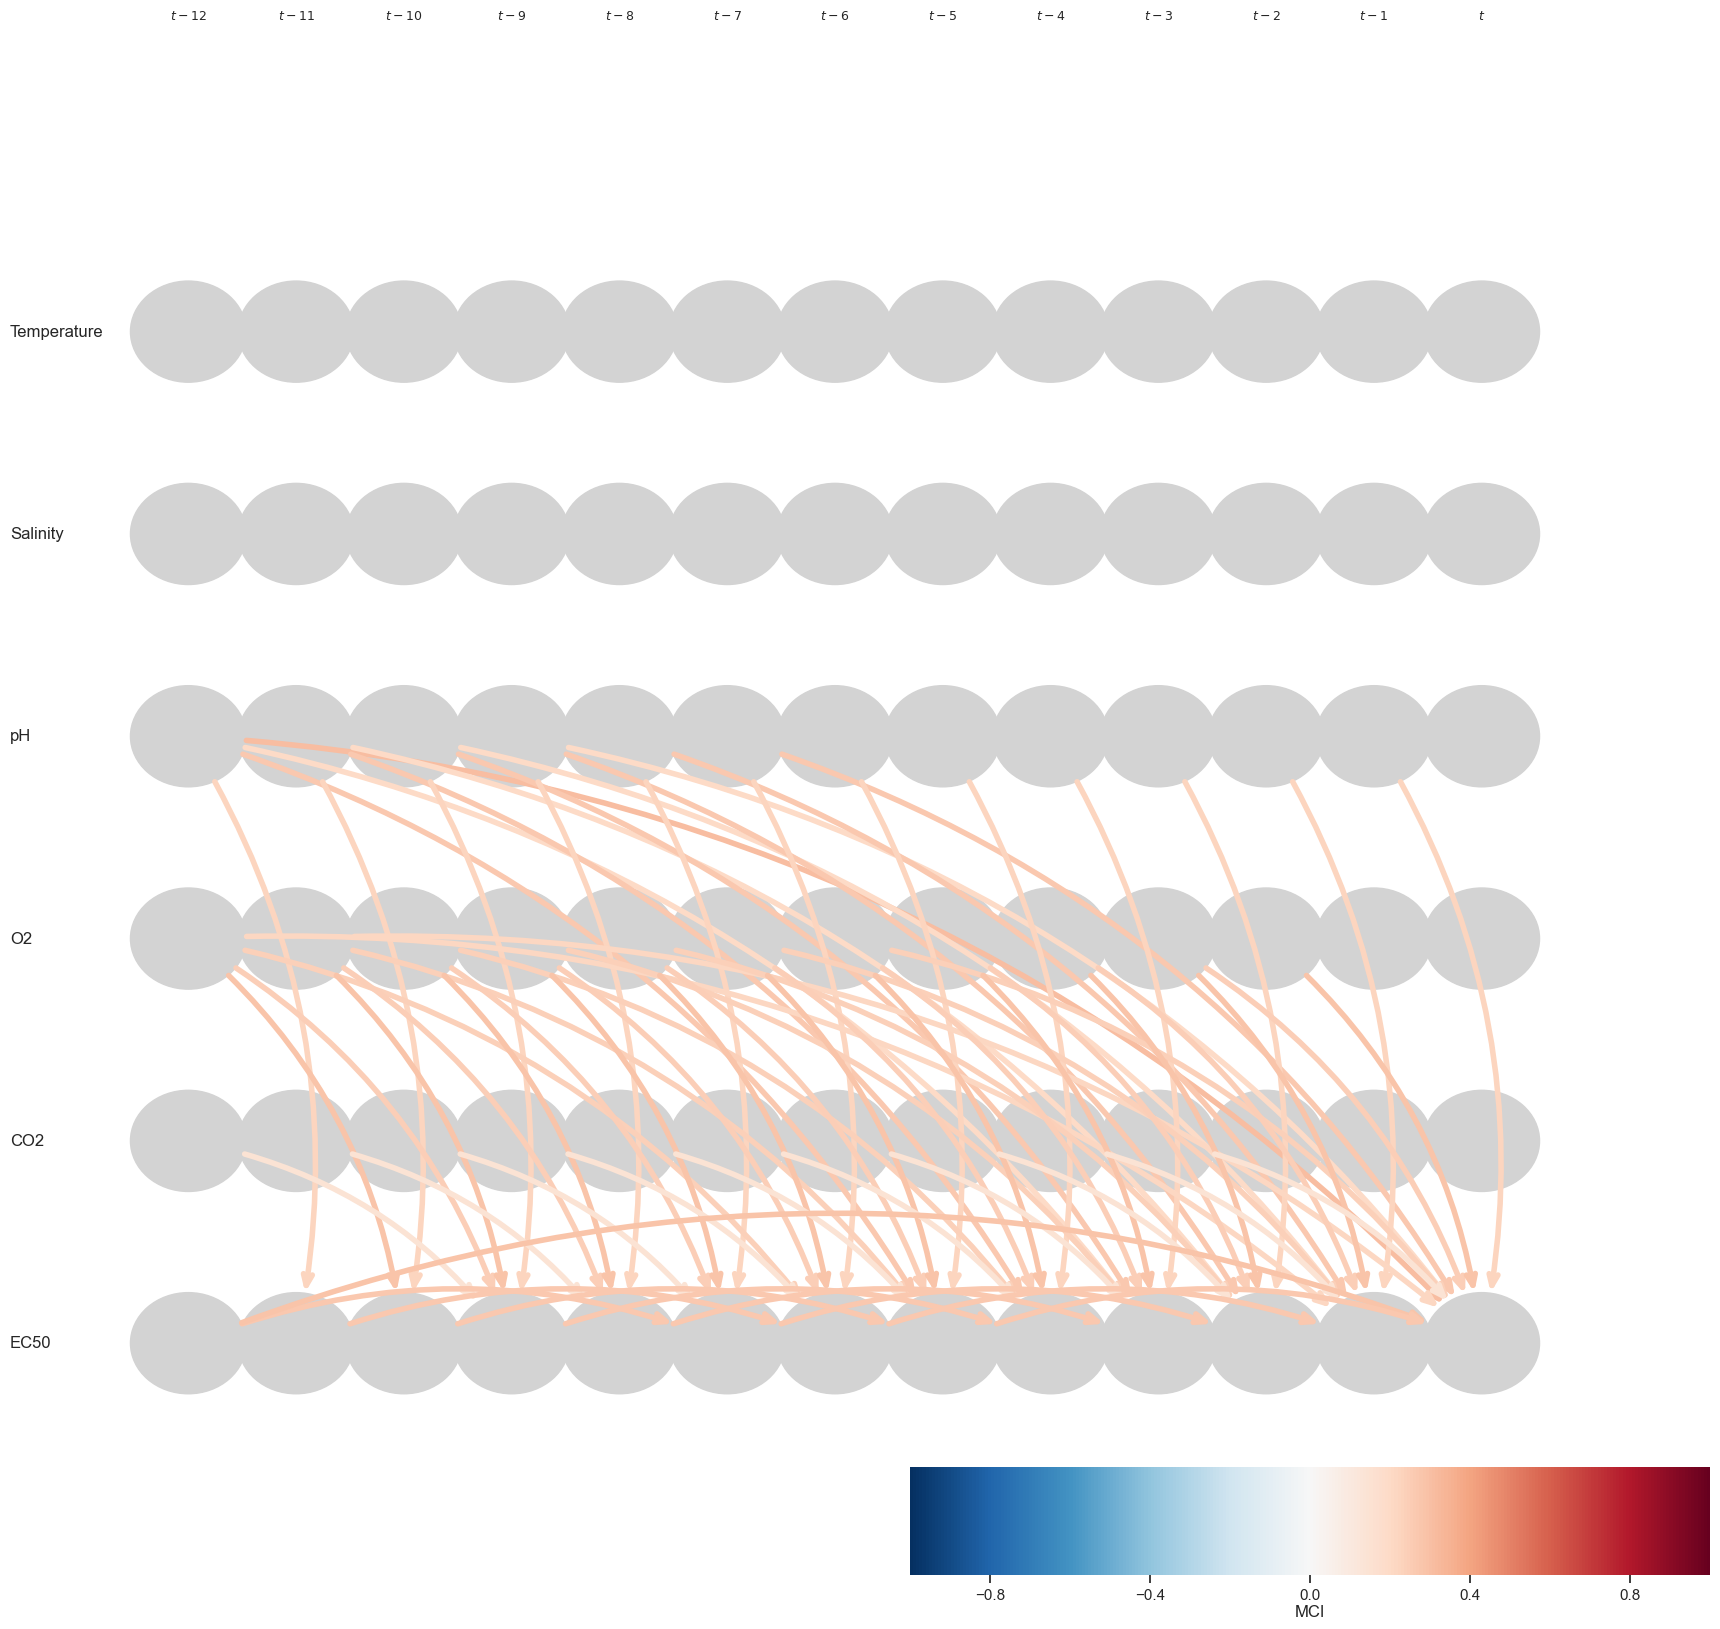

In [24]:
tp.plot_time_series_graph(
    figsize=(20, 18),
    val_matrix=results_post['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    link_colorbar_label='MCI',
    save_name = "causality-time-" + str(TAU_MAX) + "-" + str(KNN) + "-post" + anno + ".pdf",
    ); plt.show()

##### 2003-2015

In [25]:
series_values =  df_pre.values
mask = np.any(np.isnan(series_values), axis=1)
dataframe = pp.DataFrame(series_values[~mask], 
                         datatime = {0:np.arange(len(df))}, 
                         var_names=var_names)
cmi_knn = CMIknn(significance='shuffle_test', knn=KNN, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=VERBOSITY)
results_pre = pcmci_cmi_knn.run_pcmci(tau_max=TAU_MAX, pc_alpha=PC_ALPHA, alpha_level = ALPHA_LEVEL)



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 12
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Temperature has 4 link(s):
        (Temperature -5): max_pval = 0.00500, min_val =  0.104
        (pH -1): max_pval = 0.02700, min_val =  0.087
        (Temperature -1): max_pval = 0.04400, min_val =  0.082
        (Temperature -8): max_pval = 0.02300, min_val =  0.041

    Variable Salinity has 1 link(s):
        (Temperature -1): max_pval = 0.04300, min_val =  0.048

    Variable pH has 4 link(s):
        (pH -1): max_pval = 0.02000, min_val =  0.087
        (pH -8): max_pval = 0.04300, min_val =  0.102
        (CO2 -8): max_pval = 0.02100, min_val =  0.083
        (Temperature -2): max_pval = 0.02700, min_val =  0.097

    Variable O2 has 1 link(s):
        (Temperature -2): max_pval = 0.00500, min_val =  0.207

    Variable CO2 has 1 link(s):
     

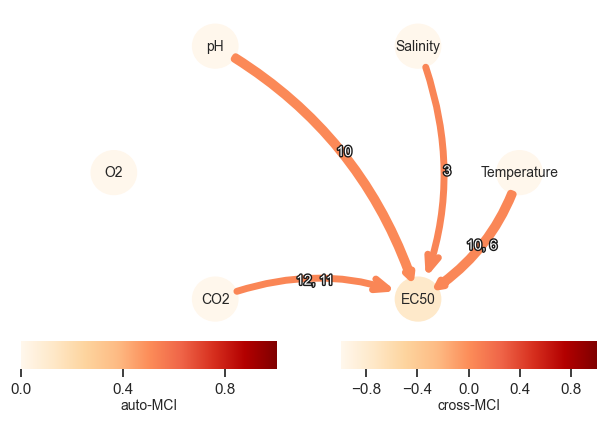

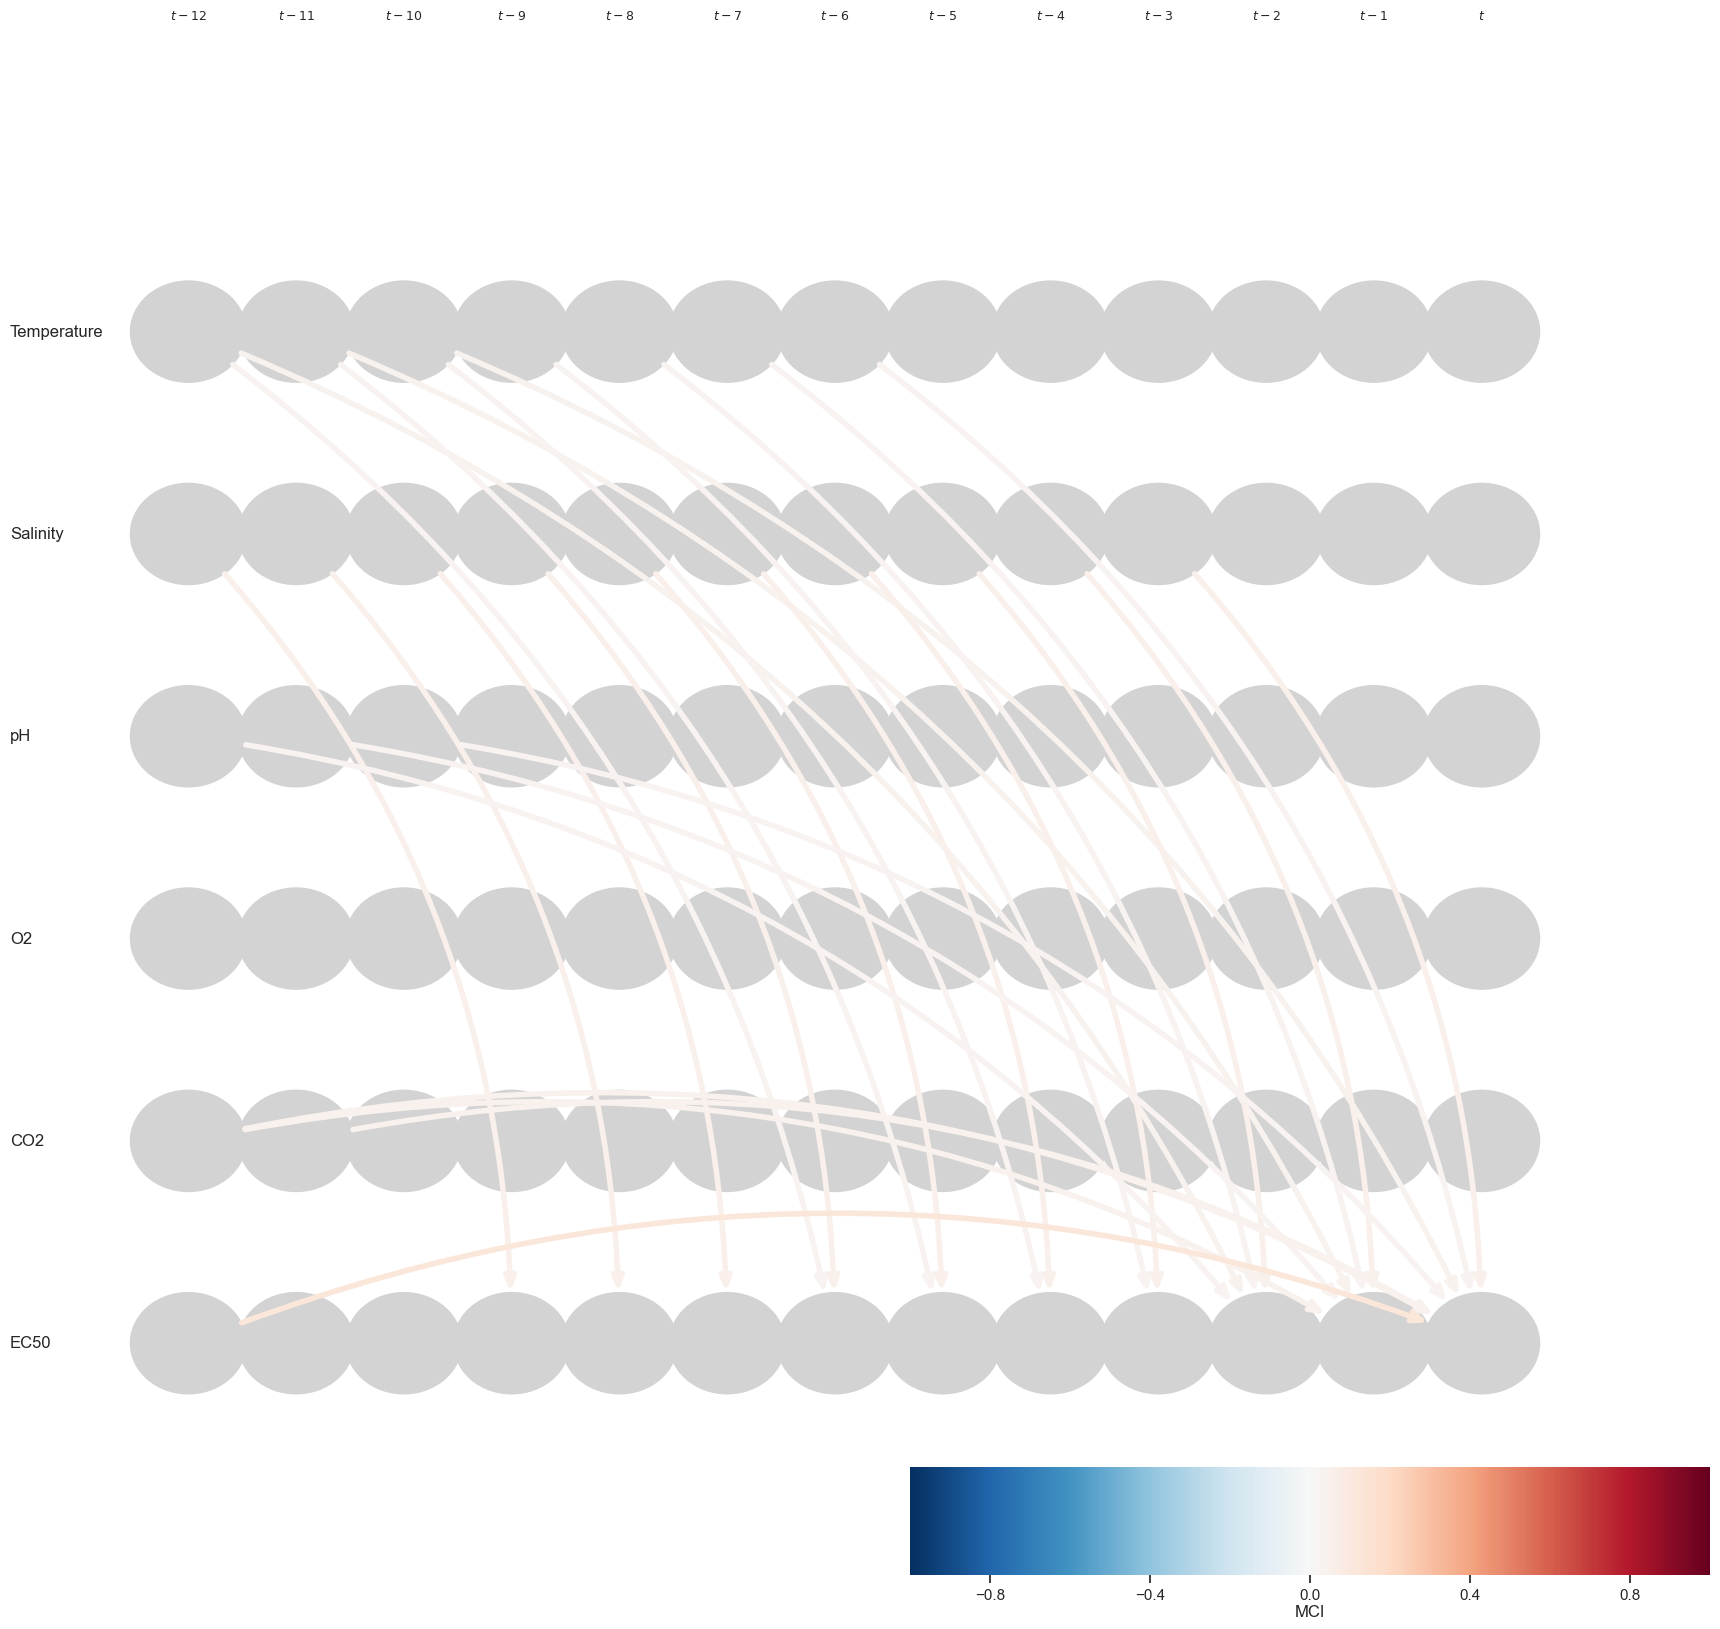

In [26]:
graph = results_pre['graph'].copy()
f = tp.plot_graph(
    val_matrix=results_pre['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    cmap_edges='OrRd',
    cmap_nodes='OrRd',
    save_name = "casuality-" + str(TAU_MAX) + "-pre" + anno + ".pdf",
    );
tp.plot_time_series_graph(
    figsize=(20, 18),
    val_matrix=results_pre['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    link_colorbar_label='MCI',
    save_name = "casuality-time-" + str(TAU_MAX) + "-" + str(KNN) + "-pre" + anno + ".pdf",
    ); plt.show()

#### Whole period

In [27]:
series_values =  df.values
mask = np.any(np.isnan(series_values), axis=1)
dataframe = pp.DataFrame(series_values[~mask], 
                         datatime = {0:np.arange(len(df))}, 
                         var_names=var_names)
cmi_knn = CMIknn(significance='shuffle_test', knn=KNN, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=VERBOSITY)
results = pcmci_cmi_knn.run_pcmci(tau_max=TAU_MAX, pc_alpha=PC_ALPHA, alpha_level = ALPHA_LEVEL)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 12
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Temperature has 1 link(s):
        (Temperature -5): max_pval = 0.00900, min_val =  0.056

    Variable Salinity has 1 link(s):
        (Temperature -3): max_pval = 0.03200, min_val =  0.067

    Variable pH has 2 link(s):
        (CO2 -1): max_pval = 0.00000, min_val =  0.670
        (Temperature -3): max_pval = 0.04900, min_val =  0.070

    Variable O2 has 1 link(s):
        (pH -11): max_pval = 0.03500, min_val =  0.061

    Variable CO2 has 2 link(s):
        (CO2 -1): max_pval = 0.00000, min_val =  0.663
        (Temperature -3): max_pval = 0.01400, min_val =  0.077

    Variable EC50 has 4 link(s):
        (EC50 -5): max_pval = 0.00700, min_val =  0.049
        (EC50 -12): max_pval = 0.01400, min_val =  0.056
        (EC50 -1): max_pval = 0.0380

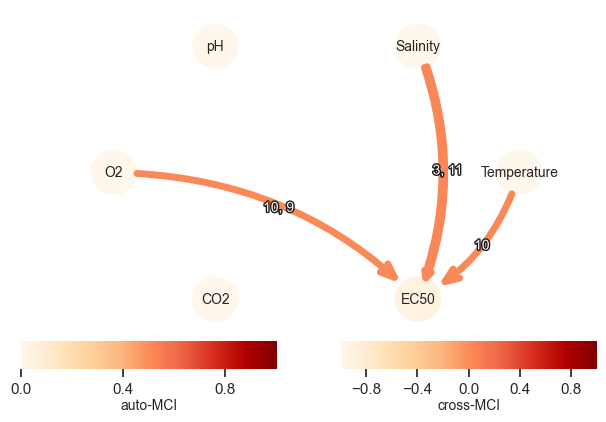

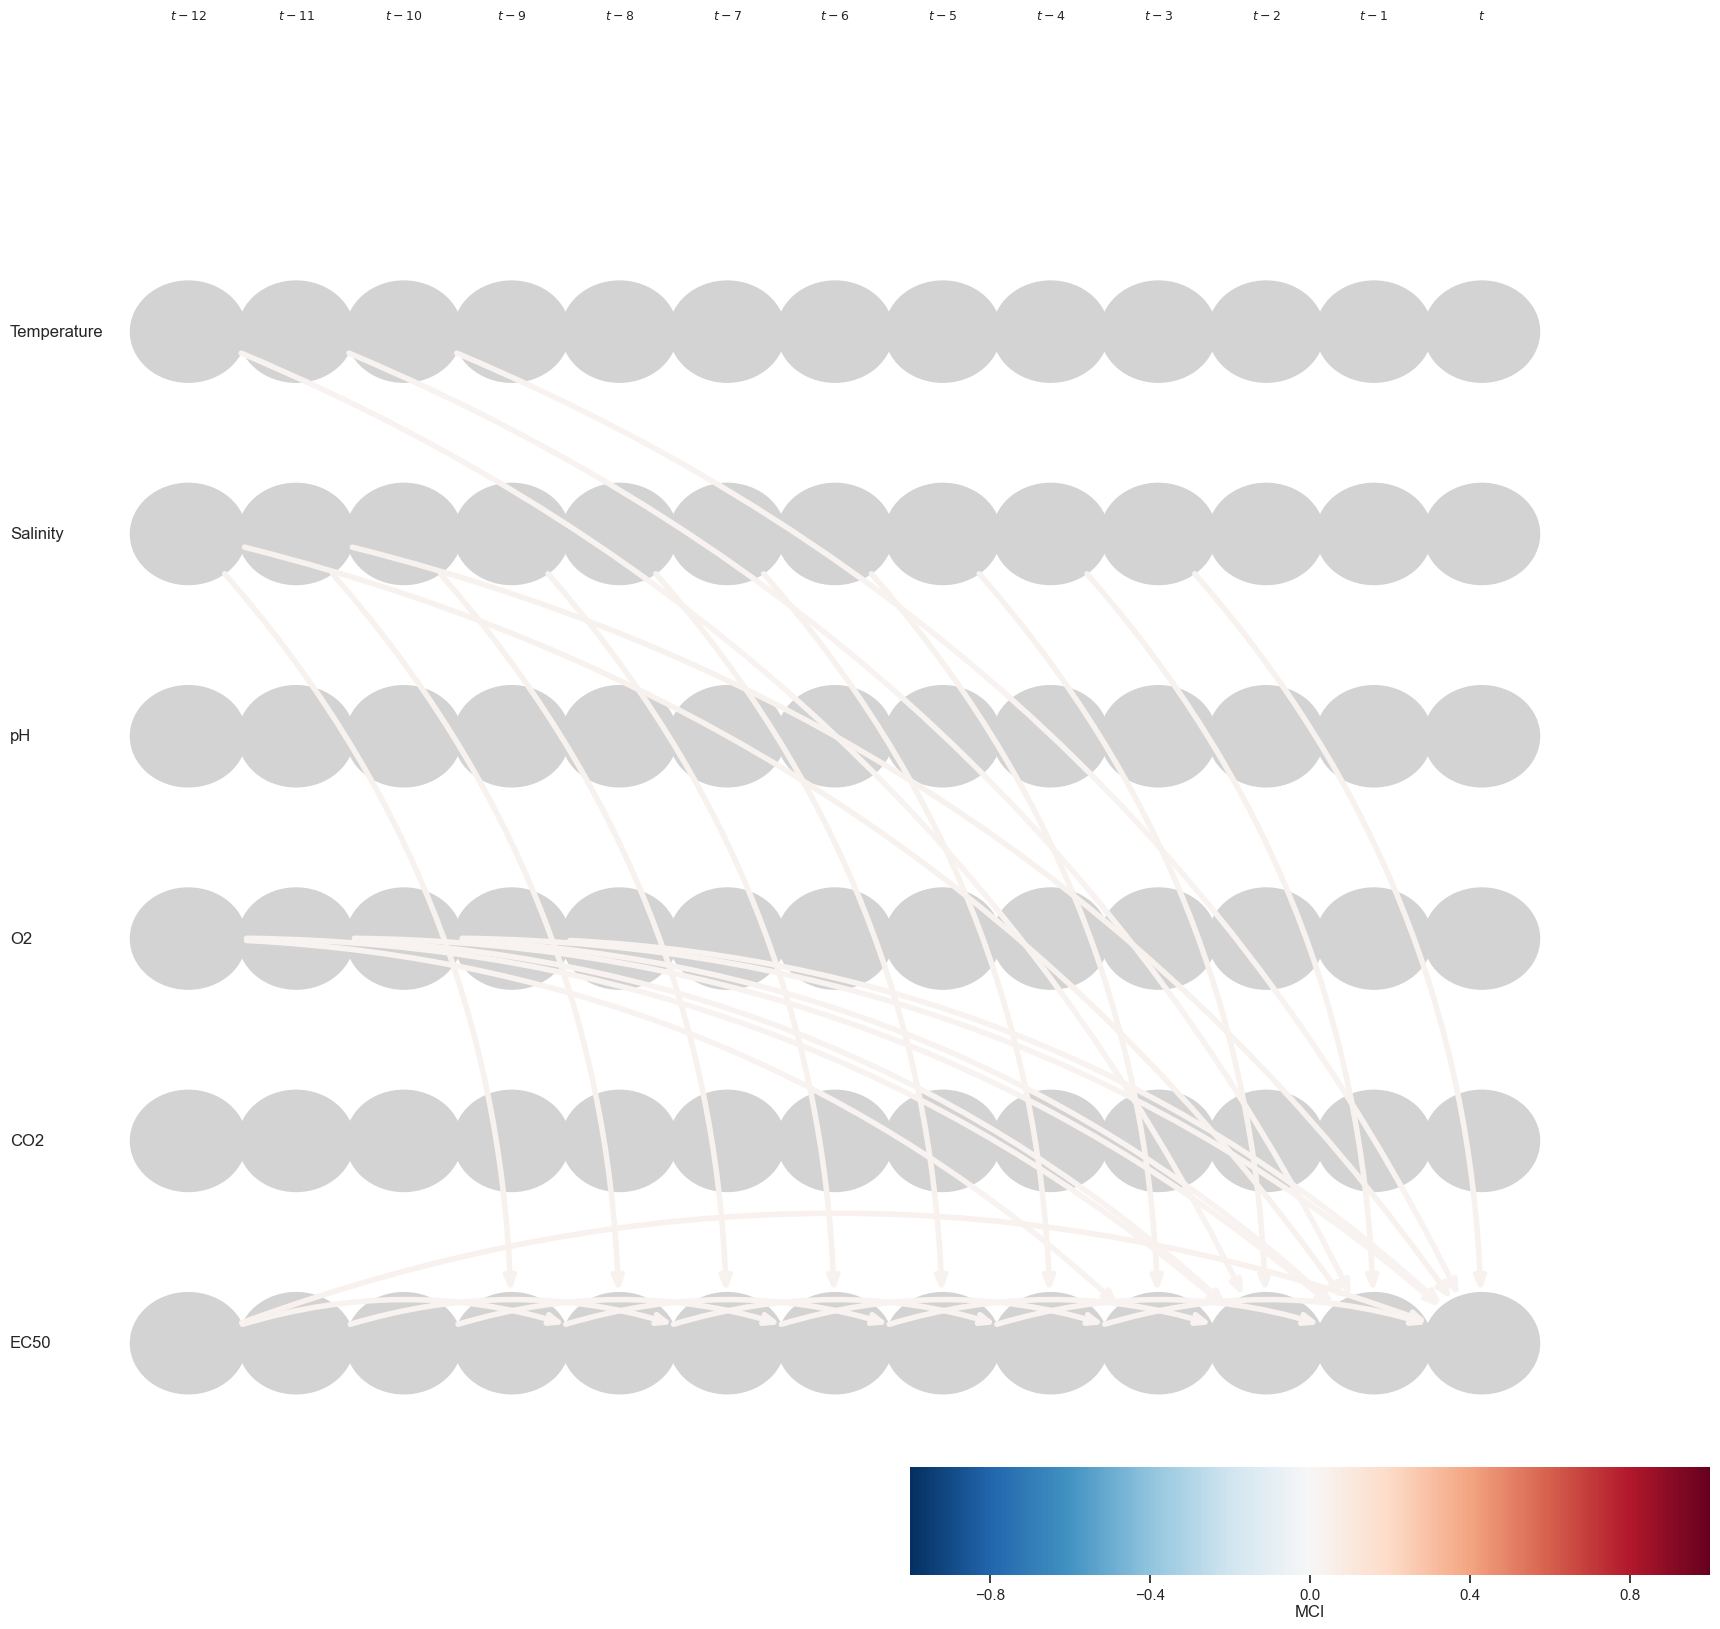

In [28]:
graph = results['graph'].copy()
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    cmap_edges='OrRd',
    cmap_nodes='OrRd',
    save_name = "casuality-" + str(TAU_MAX) + "-" + str(KNN) + "-whole" + anno + ".pdf",
    ); 
plt.show()

f= tp.plot_time_series_graph(
    figsize=(20, 18),
    val_matrix=results['val_matrix'],
    graph=mute_spurious(graph),
    var_names=var_names,
    link_colorbar_label='MCI',
    save_name = "casuality-time" + str(TAU_MAX) + "-" + str(KNN) + "-whole" + anno + ".pdf",
    ); 

### Forecast

#### Senarios

In [29]:
import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS

In [30]:
data_mean = df_pre.mean()
data_mean

Temperature     18.671503
Salinity         0.002743
pH               8.090308
O2             237.902072
CO2             40.191695
EC50             0.054896
dtype: float64

In [31]:
data_mean = df_post.mean()
data_mean

Temperature     19.062192
Salinity         0.000138
pH               8.072750
O2             237.063685
CO2             42.250640
EC50            -0.257400
dtype: float64

In [32]:
data_mean = data.mean()
data_mean

O2             237.615534
CO2             40.895385
Temperature     18.805030
Salinity        37.968813
pH               8.084307
EC50            40.416074
dtype: float64

In [33]:
import numpy as np
import pandas as pd
dataset = pd.DataFrame()
forecast_dates = np.arange(np.datetime64("2023-01-01"), np.datetime64("2042-01-01"),  np.timedelta64(1, 'M'),  dtype='datetime64[M]') 
dataset["Datetime"] = pd.to_datetime(forecast_dates)
dataset["O2"] =  data_mean["O2"]
dataset["CO2"] =  data_mean["CO2"]
dataset["EC50"] =  data_mean["EC50"]
n = dataset.shape[0]
dataset_bad, dataset_mean, dataset_good = dataset.copy(), dataset.copy(), dataset.copy()

In [34]:

dataset_bad_temperature = np.linspace(data_mean["Temperature"], 22.48, n)
dataset_bad_salinity = np.linspace(data_mean["Salinity"], 38.84, n)
dataset_bad_ph = np.linspace(data_mean["pH"],  7.626, n)

dataset_bad["Temperature"] = dataset_bad_temperature
dataset_bad["Salinity"] = dataset_bad_salinity
dataset_bad["pH"] = dataset_bad_ph

dataset_good_temperature = np.linspace(data_mean["Temperature"], 19.48, n)
dataset_good_salinity = np.linspace(data_mean["Salinity"], 38.43, n)
dataset_good_ph = np.linspace(data_mean["pH"], 7.98916, n)

dataset_good["Temperature"] = dataset_good_temperature
dataset_good["Salinity"] = dataset_good_salinity
dataset_good["pH"] = dataset_good_ph

dataset_mean_temperature = np.linspace(data_mean["Temperature"], 20.98, n)
dataset_mean_salinity = np.linspace(data_mean["Salinity"], 38.608, n)
dataset_mean_ph = np.linspace(data_mean["pH"], 7.80758, n)

dataset_mean["Temperature"] = dataset_mean_temperature 
dataset_mean["Salinity"] = dataset_mean_salinity 
dataset_mean["pH"] = dataset_mean_ph 
 
dataset_bad.to_csv('data_LSTMS_bad2.csv')
dataset_mean.to_csv('data_LSTMS_mean2.csv')
dataset_good.to_csv('data_LSTMS_good2.csv')


In [35]:
df = data
###apply seasonal to scenarios
ss_temperature = seasonal_temperature.to_numpy()[len(seasonal_temperature)-n:]
tt_temperature = 1.0#trend.to_numpy()[len(trend)-n:]
#tt = sklearn.preprocessing.minmax_scale(tt, feature_range=(1,1.001))

ss_pH = seasonal_pH.to_numpy()[len(seasonal_pH)-n:]
tt_pH = 1.0#trend.to_numpy()[len(trend)-n:]
#tt = sklearn.preprocessing.minmax_scale(tt, feature_range=(1,1.001))

ss_salinity= seasonal_salinity.to_numpy()[len(seasonal_salinity)-n:]
tt_salinity = 1.0#trend.to_numpy()[len(trend)-n:]
#tt = sklearn.preprocessing.minmax_scale(tt, feature_range=(1,1.001))

ss_o2 = seasonal_o2.to_numpy()[len(seasonal_o2)-n:]
tt_o2 = 1.0#trend.to_numpy()[len(trend)-n:]
#tt = sklearn.preprocessing.minmax_scale(tt, feature_range=(1,1.001))

ss_co2 = seasonal_co2.to_numpy()[len(seasonal_co2)-n:]
tt_co2 = 1.0#trend.to_numpy()[len(trend)-n:]
#tt = sklearn.preprocessing.minmax_scale(tt, feature_range=(1,1.001))


dataset_bad["Temperature"] = dataset_bad["Temperature"].mul(ss_temperature, axis=0).mul(tt_temperature, axis=0)
dataset_bad["Salinity"] = dataset_bad["Salinity"].mul(ss_salinity, axis=0).mul(tt_salinity, axis=0)
dataset_bad["pH"] = dataset_bad["pH"].mul(ss_pH, axis=0).mul(tt_pH, axis=0)
dataset_bad["O2"] = dataset_bad["O2"].mul(ss_o2, axis=0).mul(tt_o2, axis=0)
dataset_bad["CO2"] = dataset_bad["CO2"].mul(ss_co2, axis=0).mul(tt_co2, axis=0)


dataset_good["Temperature"] = dataset_good["Temperature"].mul(ss_temperature, axis=0).mul(tt_temperature, axis=0)
dataset_good["Salinity"] = dataset_good["Salinity"].mul(ss_salinity, axis=0).mul(tt_salinity, axis=0)
dataset_good["pH"] = dataset_good["pH"].mul(ss_pH, axis=0).mul(tt_pH, axis=0)
dataset_good["O2"] = dataset_good["O2"].mul(ss_o2, axis=0).mul(tt_o2, axis=0)
dataset_good["CO2"] = dataset_good["CO2"].mul(ss_co2, axis=0).mul(tt_co2, axis=0)

dataset_mean["Temperature"] = dataset_mean["Temperature"].mul(ss_temperature, axis=0).mul(tt_temperature, axis=0)
dataset_mean["Salinity"] = dataset_mean["Salinity"].mul(ss_salinity, axis=0).mul(tt_salinity, axis=0)
dataset_mean["pH"] = dataset_mean["pH"].mul(ss_pH, axis=0).mul(tt_pH, axis=0)
dataset_mean["O2"] = dataset_mean["O2"].mul(ss_o2, axis=0).mul(tt_o2, axis=0)
dataset_mean["CO2"] = dataset_mean["CO2"].mul(ss_co2, axis=0).mul(tt_co2, axis=0)


 ### Forecast with ARIMA: CO2

In [36]:
def plot_with_int_all(a,label_a, b, label_b, c, label_c, real, label_real, rename) :
    fig, ax = plt.subplots(1, 1, figsize = (20, 7))

    df_plot = pd.concat([Y_train_df, a]).set_index('ds')
    df_plot.rename(columns = {'AutoARIMA':label_a}, inplace = True)
    df_plot.rename(columns = {real:rename}, inplace = True)
    df_plot[[rename]].plot(ax=ax, linewidth=2, color='blue')
    df_plot[[label_a]].plot(ax=ax, linewidth=2, label=label_a, color='green')
    ax.fill_between(df_plot.index, 
                    df_plot['AutoARIMA-lo-95'], 
                    df_plot['AutoARIMA-hi-95'],
                    alpha=.1,
                    color='green'#,
                    #label='auto_arima_level_95' + label_a
                    )

    df_plot = pd.concat([Y_train_df, b]).set_index('ds')
    df_plot.rename(columns = {'AutoARIMA':label_b}, inplace = True)
    df_plot[[label_b]].plot(ax=ax, linewidth=2, label=label_b,color='orange')
    ax.fill_between(df_plot.index, 
                    df_plot['AutoARIMA-lo-95'], 
                    df_plot['AutoARIMA-hi-95'],
                    alpha=.1,
                    color='orange'#,
                    #label='auto_arima_level_95' + label_b
                    )

    df_plot = pd.concat([Y_train_df, c]).set_index('ds')
    df_plot.rename(columns = {'AutoARIMA':label_c}, inplace = True)
    df_plot[[label_c]].plot(ax=ax, linewidth=2, label=label_c,color='red')
    ax.fill_between(df_plot.index, 
                    df_plot['AutoARIMA-lo-95'], 
                    df_plot['AutoARIMA-hi-95'],
                    alpha=.1,
                    color='red'#,
                    #label='auto_arima_level_95' + label_c
                    )


    #ax.set_title('EC50 Forecast', fontsize=22)
    ax.set_ylabel(label_real, fontsize=20)
    ax.set_xlabel('Date', fontsize=20)
    ax.legend(prop={'size': 15})
    plt.xlim(np.datetime64("2003-01-01"), np.datetime64("2040-01-01"))
    ax.set_ylim([0, 80])
    
    ax = plt.gca()
    ax.grid(True)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)
    fig.savefig("forecast.pdf")

In [37]:
Y_df = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': df["CO2"],
                     #'O2': df["EC50"],
                     #'Salinity': df["Salinity"],
                     #'pH': df["pH"],
                     #'Temperature': df["Temperature"]
                     })
Y_df_full = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': df["CO2"],
                     #'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_df_woEC50 = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': df["CO2"],
                     #'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_train_df = Y_df_full[Y_df_full.ds<='2022-01-01']
Y_train_df_woEC50 = Y_df[Y_df_full.ds<='2022-01-01']
Y_test_df_woEC50 = Y_df[Y_df_full.ds>'2022-01-01']

scenario_bad = pd.DataFrame({'unique_id': np.ones(len(dataset_bad)),
                     'ds': dataset_bad["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_bad["CO2"],
                     #'O2': dataset_bad["O2"],
                     'Salinity': dataset_bad["Salinity"],
                     'pH': dataset_bad["pH"],
                     'Temperature': dataset_bad["Temperature"]
                     })

scenario_good = pd.DataFrame({'unique_id': np.ones(len(dataset_good)),
                     'ds': dataset_good["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_good["CO2"],
                     #'O2': dataset_good["O2"],
                     'Salinity': dataset_good["Salinity"],
                     'pH': dataset_good["pH"],
                     'Temperature': dataset_good["Temperature"]
                     })

scenario_mean = pd.DataFrame({'unique_id': np.ones(len(dataset_mean)),
                     'ds': dataset_mean["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_mean["CO2"],
                     #'O2': dataset_mean["O2"],
                     'Salinity': dataset_mean["Salinity"],
                     'pH': dataset_mean["pH"],
                     'Temperature': dataset_mean["Temperature"]
                     })

xreg_test = Y_df_woEC50[Y_df_full.ds>'2022-01-01']

xreg_test =  pd.concat([xreg_test], ignore_index=True)
xreg_test["ds"] = pd.date_range(start='2022-01-01', periods=len(xreg_test), freq='M')

In [38]:
#Define the parameters that you want to use in your models. 
season_length = 12
# Note: For all models the following parameters are passed automaticly and don't need to be declared: (X, h, future_xreg)

models = [
    AutoARIMA(season_length=season_length)#,
    #ETS(season_length=season_length, model='ZMZ')
]
model = StatsForecast(
    df=Y_train_df, 
    models=models,
    freq='M', 
    n_jobs=-1,
)


In [39]:
horizon = len(xreg_test) 
Y_hat_df_xreg = model.forecast(horizon, X_df=xreg_test.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg = Y_hat_df_xreg.reset_index()
df_plot = pd.concat([Y_train_df, Y_hat_df_xreg]).set_index('ds')
df_plot.columns = df_plot.columns.str.replace('AutoARIMA', 'TEST')

In [40]:
horizon = len(scenario_bad) 
Y_hat_df_xreg_bad = model.forecast(horizon, X_df=scenario_bad.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_bad = Y_hat_df_xreg_bad.reset_index()
df_plot_bad = pd.concat([Y_train_df, Y_hat_df_xreg_bad]).set_index('ds')
df_plot_bad.columns = df_plot_bad.columns.str.replace('AutoARIMA', 'BAD')

In [41]:
horizon = len(scenario_good) 
Y_hat_df_xreg_good = model.forecast(horizon, X_df=scenario_good.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_good = Y_hat_df_xreg_good.reset_index()
df_plot_good = pd.concat([Y_train_df, Y_hat_df_xreg_good]).set_index('ds')
df_plot_good.columns = df_plot_good.columns.str.replace('AutoARIMA', 'GOOD')

In [42]:
horizon = len(scenario_mean) 
Y_hat_df_xreg_mean = model.forecast(horizon, X_df=scenario_mean.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_mean = Y_hat_df_xreg_mean.reset_index()
df_plot_mean = pd.concat([Y_train_df, Y_hat_df_xreg_mean]).set_index('ds')
df_plot_mean.columns = df_plot_mean.columns.str.replace('AutoARIMA', 'MEAN')

In [43]:
Y_hat_df_intervals_good = model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
df_plot = pd.concat([Y_train_df, Y_hat_df_intervals_good]).set_index('ds')

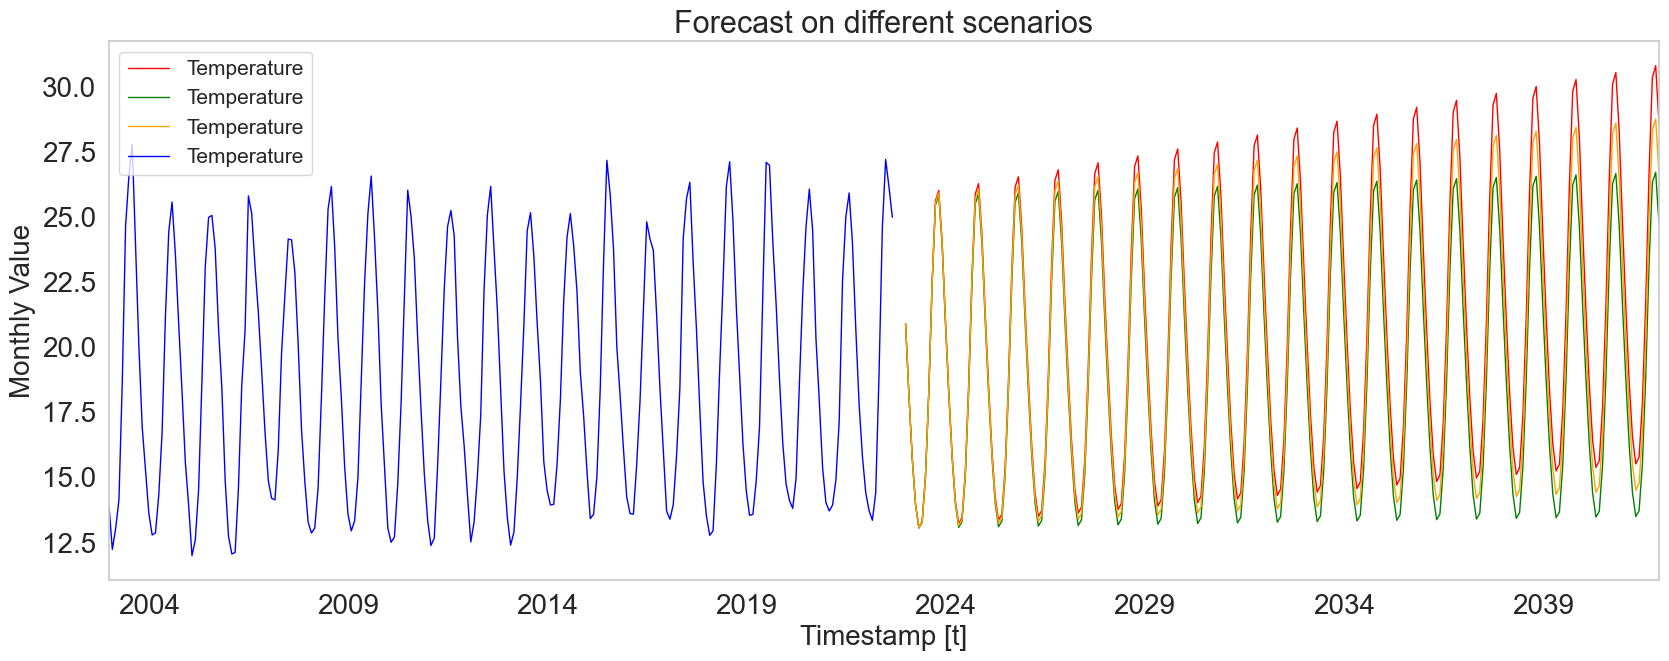

In [46]:
#We are going to plot the models against the real values of test.

fig, ax = plt.subplots(1, 1, figsize = (20, 7))

bad_temp = scenario_bad[["ds", "Temperature"]]

bad_temp = bad_temp.set_index('ds')
bad_temp["Temperature"].plot(ax=ax, linewidth=1, color='red')

good_temp = scenario_good[["ds", "Temperature"]]
good_temp = good_temp.set_index("ds")
good_temp["Temperature"].plot(ax=ax, linewidth=1, color='green')

mean_temp = scenario_mean[["ds", "Temperature"]]
mean_temp = mean_temp.set_index("ds")
mean_temp["Temperature"].plot(ax=ax, linewidth=1, color='orange')

Y_df = pd.DataFrame({
                     'ds': df["Datetime"],
                     'Temperature': df["Temperature"]})
Y_df = Y_df.set_index("ds")

Y_df["Temperature"].plot(ax=ax, linewidth=1, color='blue')

dataset_good["CO2"]= df_plot_good[['GOOD']]['GOOD'].array[-horizon:]
dataset_mean["CO2"] = df_plot_mean[['MEAN']]['MEAN'].array[-horizon:]
dataset_bad["CO2"] = df_plot_bad[['BAD']]['BAD'].array[-horizon:]

fd_plot_real = Y_df_full.set_index('ds')

ax.set_title('Forecast on different scenarios', fontsize=22)
ax.set_ylabel('Monthly Value', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

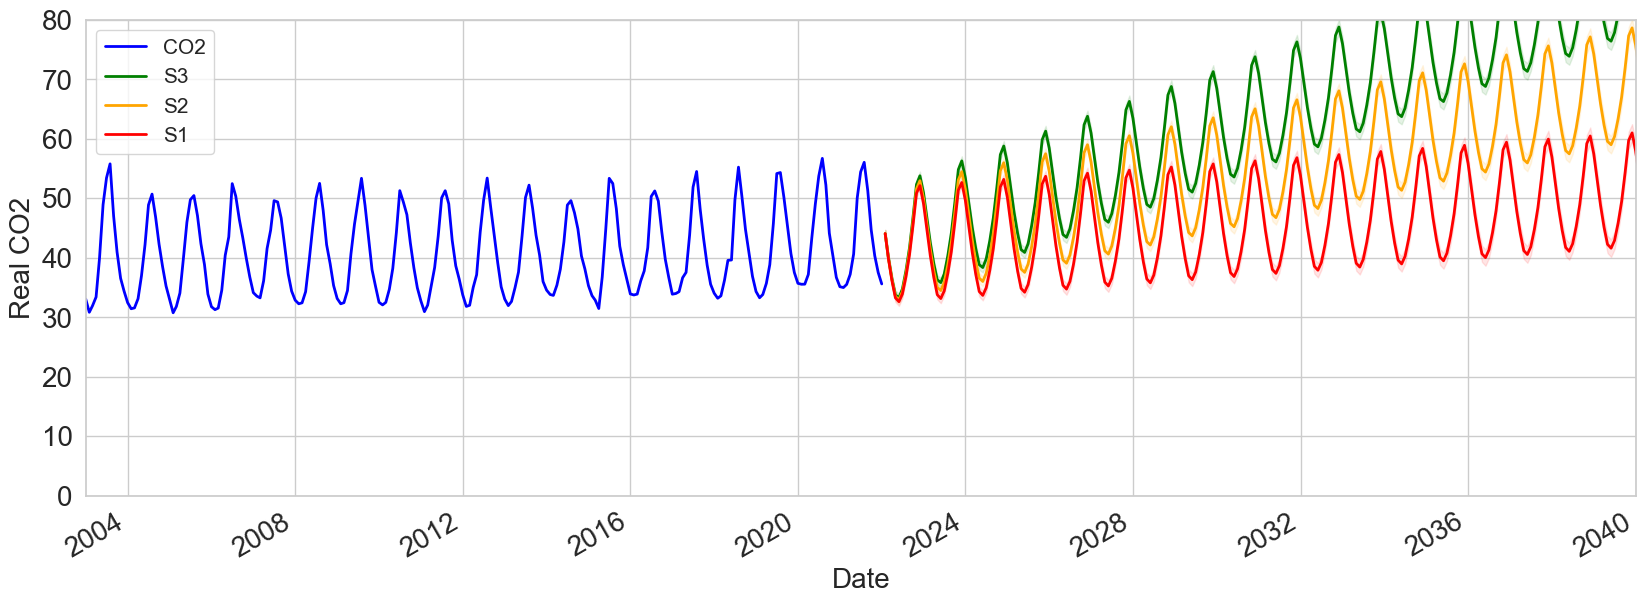

In [48]:

# Then we plot the intervals
def plot_with_int(Y_hat_df_intervals,label) :
    fig, ax = plt.subplots(1, 1, figsize = (20, 7))
    df_plot = pd.concat([Y_train_df, Y_hat_df_intervals]).set_index('ds')
    df_plot[['CO2', 'AutoARIMA']].plot(ax=ax, linewidth=2)
    ax.fill_between(df_plot.index, 
                    df_plot['AutoARIMA-lo-95'], 
                    df_plot['AutoARIMA-hi-95'],
                    alpha=.2,
                    color='orange',
                    label='auto_arima_level_95')
    ax.set_title('CO2 Forecast : ' + label, fontsize=22)
    ax.set_ylabel('Monthly Values', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.set_ylim([0, 150])
    ax.grid()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

###BAD
Y_hat_df_intervals = model.forecast(horizon, level=(80, 95), X_df=scenario_bad.set_index('unique_id'))
#plot_with_int(Y_hat_df_intervals, "BAD")

#####GOOD
Y_hat_df_intervals = model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
#plot_with_int(Y_hat_df_intervals, "GOOD")
# Then we plot the intervals

#####MEAN
Y_hat_df_intervals = model.forecast(horizon, level=(80, 95), X_df=scenario_mean.set_index('unique_id'))
#plot_with_int(Y_hat_df_intervals, "MEAN")



bad = model.forecast(horizon, level=(80, 95), X_df=scenario_bad.set_index('unique_id'))
good= model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
mean = model.forecast(horizon, level=(80, 95), X_df=scenario_mean.set_index('unique_id'))

plot_with_int_all(bad, "S3",mean, "S2",good, "S1", "CO2", "Real CO2", "CO2")



 ### Forecast with ARIMA: O2

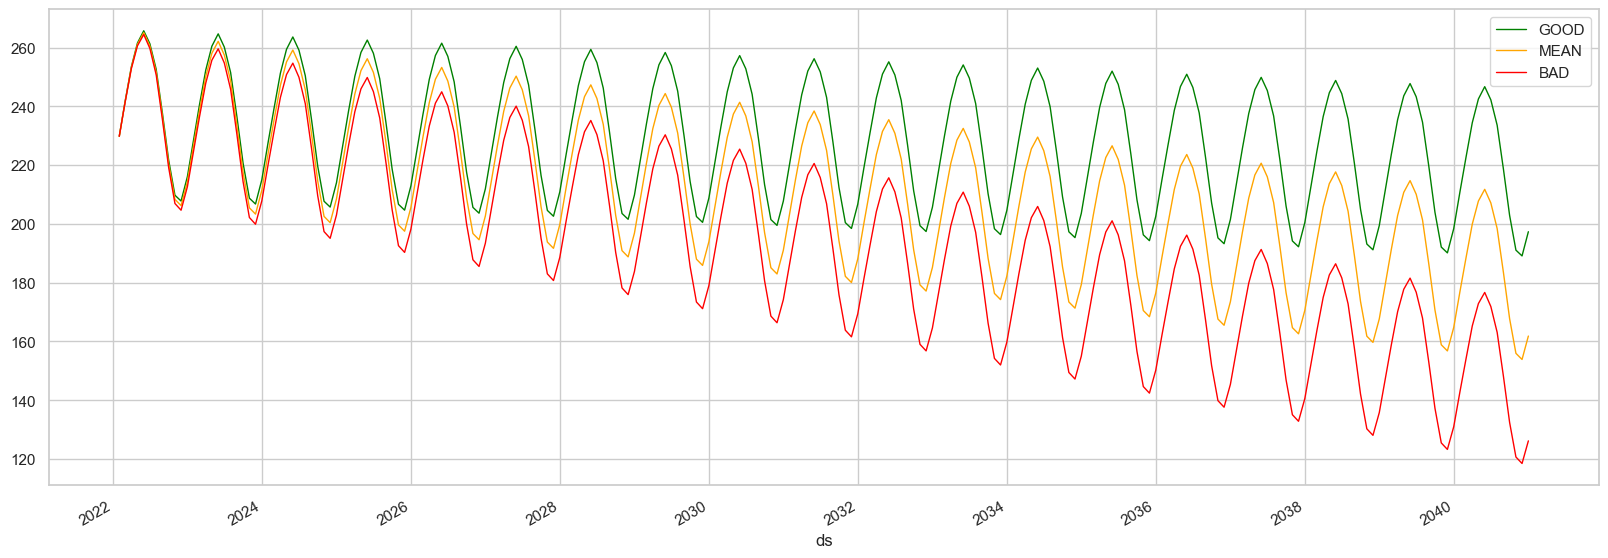

In [56]:
Y_df = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': df["CO2"],
                     'O2': df["EC50"],
                     #'Salinity': df["Salinity"],
                     #'pH': df["pH"],
                     #'Temperature': df["Temperature"]
                     })
Y_df_full = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': df["CO2"],
                     'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_df_woEC50 = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': df["CO2"],
                     #'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_train_df = Y_df_full[Y_df_full.ds<='2022-01-01']
Y_train_df_woEC50 = Y_df[Y_df_full.ds<='2022-01-01']
Y_test_df_woEC50 = Y_df[Y_df_full.ds>'2022-01-01']

scenario_bad = pd.DataFrame({'unique_id': np.ones(len(dataset_bad)),
                     'ds': dataset_bad["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_bad["CO2"],
                     #'O2': dataset_bad["O2"],
                     'Salinity': dataset_bad["Salinity"],
                     'pH': dataset_bad["pH"],
                     'Temperature': dataset_bad["Temperature"]
                     })

scenario_good = pd.DataFrame({'unique_id': np.ones(len(dataset_good)),
                     'ds': dataset_good["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_good["CO2"],
                     #'O2': dataset_good["O2"],
                     'Salinity': dataset_good["Salinity"],
                     'pH': dataset_good["pH"],
                     'Temperature': dataset_good["Temperature"]
                     })

scenario_mean = pd.DataFrame({'unique_id': np.ones(len(dataset_mean)),
                     'ds': dataset_mean["Datetime"],
                     #'EC50': df["EC50"],
                     #'CO2': dataset_mean["CO2"],
                     #'O2': dataset_mean["O2"],
                     'Salinity': dataset_mean["Salinity"],
                     'pH': dataset_mean["pH"],
                     'Temperature': dataset_mean["Temperature"]
                     })

xreg_test = Y_df_woEC50[Y_df_full.ds>'2022-01-01']

xreg_test =  pd.concat([xreg_test], ignore_index=True)
xreg_test["ds"] = pd.date_range(start='2022-01-01', periods=len(xreg_test), freq='M')

#Define the parameters that you want to use in your models. 
season_length = 12
# Note: For all models the following parameters are passed automaticly and don't need to be declared: (X, h, future_xreg)

models = [
    AutoARIMA(season_length=season_length)#,
    #ETS(season_length=season_length, model='ZMZ')
]
model = StatsForecast(
    df=Y_train_df, 
    models=models,
    freq='M', 
    n_jobs=-1,
)

horizon = len(xreg_test) 
Y_hat_df_xreg = model.forecast(horizon, X_df=xreg_test.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg = Y_hat_df_xreg.reset_index()
df_plot = pd.concat([Y_train_df, Y_hat_df_xreg]).set_index('ds')
df_plot.columns = df_plot.columns.str.replace('AutoARIMA', 'TEST')

horizon = len(scenario_bad) 
Y_hat_df_xreg_bad = model.forecast(horizon, X_df=scenario_bad.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_bad = Y_hat_df_xreg_bad.reset_index()
df_plot_bad = pd.concat([Y_train_df, Y_hat_df_xreg_bad]).set_index('ds')
df_plot_bad.columns = df_plot_bad.columns.str.replace('AutoARIMA', 'BAD')

horizon = len(scenario_good) 
Y_hat_df_xreg_good = model.forecast(horizon, X_df=scenario_good.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_good = Y_hat_df_xreg_good.reset_index()
df_plot_good = pd.concat([Y_train_df, Y_hat_df_xreg_good]).set_index('ds')
df_plot_good.columns = df_plot_good.columns.str.replace('AutoARIMA', 'GOOD')

horizon = len(scenario_mean) 
Y_hat_df_xreg_mean = model.forecast(horizon, X_df=scenario_mean.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_mean = Y_hat_df_xreg_mean.reset_index()
df_plot_mean = pd.concat([Y_train_df, Y_hat_df_xreg_mean]).set_index('ds')
df_plot_mean.columns = df_plot_mean.columns.str.replace('AutoARIMA', 'MEAN')


Y_hat_df_intervals_good = model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
df_plot = pd.concat([Y_train_df, Y_hat_df_intervals_good]).set_index('ds')


#We are going to plot the models againts the real values of test.

fig, ax = plt.subplots(1, 1, figsize = (20, 7))

#df_plot[['EC50', 'TEST']].plot(ax=ax, linewidth=10)
df_plot_good[['GOOD']].plot(ax=ax, linewidth=1, color='green')
df_plot_mean[['MEAN']].plot(ax=ax, linewidth=1, color='orange')
df_plot_bad[['BAD']].plot(ax=ax, linewidth=1, color='red')

dataset_good["O2"]= df_plot_good[['GOOD']]['GOOD'].array[-horizon:]
dataset_mean["O2"] = df_plot_mean[['MEAN']]['MEAN'].array[-horizon:]
dataset_bad["O2"] = df_plot_bad[['BAD']]['BAD'].array[-horizon:]

bad = model.forecast(horizon, level=(80, 95), X_df=scenario_bad.set_index('unique_id'))
good= model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
mean = model.forecast(horizon, level=(80, 95), X_df=scenario_mean.set_index('unique_id'))

#plot_with_int_all(bad, "S3",mean, "S2",good, "S1", "O2", "Real O2", "O2")

 ### Forecast with ARIMA: EC50

In [57]:
dataset_good["O2"]= df_plot_good[['GOOD']]['GOOD'].array[-horizon:]
dataset_mean["O2"] = df_plot_mean[['MEAN']]['MEAN'].array[-horizon:]
dataset_bad["O2"] = df_plot_bad[['BAD']]['BAD'].array[-horizon:]

In [58]:
Y_df = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     'EC50': df["EC50"],
                     #'CO2': df["CO2"],
                     #'O2': df["EC50"],
                     #'Salinity': df["Salinity"],
                     #'pH': df["pH"],
                     #'Temperature': df["Temperature"]
                     })
Y_df_full = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     'EC50': df["EC50"],
                     'CO2': df["CO2"],
                     'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_df_woEC50 = pd.DataFrame({'unique_id': np.ones(len(df)),
                     'ds': df["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': df["CO2"],
                     'O2': df["O2"],
                     'Salinity': df["Salinity"],
                     'pH': df["pH"],
                     'Temperature': df["Temperature"]
                     })

Y_train_df = Y_df_full[Y_df_full.ds<='2022-01-01']
Y_train_df_woEC50 = Y_df[Y_df_full.ds<='2022-01-01']
Y_test_df_woEC50 = Y_df[Y_df_full.ds>'2022-01-01']

scenario_bad = pd.DataFrame({'unique_id': np.ones(len(dataset_bad)),
                     'ds': dataset_bad["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': dataset_bad["CO2"],
                     'O2': dataset_bad["O2"],
                     'Salinity': dataset_bad["Salinity"],
                     'pH': dataset_bad["pH"],
                     'Temperature': dataset_bad["Temperature"]
                     })

scenario_good = pd.DataFrame({'unique_id': np.ones(len(dataset_good)),
                     'ds': dataset_good["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': dataset_good["CO2"],
                     'O2': dataset_good["O2"],
                     'Salinity': dataset_good["Salinity"],
                     'pH': dataset_good["pH"],
                     'Temperature': dataset_good["Temperature"]
                     })

scenario_mean = pd.DataFrame({'unique_id': np.ones(len(dataset_mean)),
                     'ds': dataset_mean["Datetime"],
                     #'EC50': df["EC50"],
                     'CO2': dataset_mean["CO2"],
                     'O2': dataset_mean["O2"],
                     'Salinity': dataset_mean["Salinity"],
                     'pH': dataset_mean["pH"],
                     'Temperature': dataset_mean["Temperature"]
                     })

xreg_test = Y_df_woEC50[Y_df_full.ds>'2022-01-01']

xreg_test =  pd.concat([xreg_test], ignore_index=True)
xreg_test["ds"] = pd.date_range(start='2022-01-01', periods=len(xreg_test), freq='M')

#Define the parameters that you want to use in your models. 
season_length = 12
# Note: For all models the following parameters are passed automatically and don't need to be declared: (X, h, future_xreg)

models = [
    AutoARIMA(season_length=season_length)#,
    #ETS(season_length=season_length, model='ZMZ')
]
model = StatsForecast(
    df=Y_train_df, 
    models=models,
    freq='M', 
    n_jobs=-1,
)


In [59]:

horizon = len(xreg_test) 
Y_hat_df_xreg = model.forecast(horizon, X_df=xreg_test.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg = Y_hat_df_xreg.reset_index()
df_plot = pd.concat([Y_train_df, Y_hat_df_xreg]).set_index('ds')
df_plot.columns = df_plot.columns.str.replace('AutoARIMA', 'TEST')

horizon = len(scenario_bad) 
Y_hat_df_xreg_bad = model.forecast(horizon, X_df=scenario_bad.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_bad = Y_hat_df_xreg_bad.reset_index()
df_plot_bad = pd.concat([Y_train_df, Y_hat_df_xreg_bad]).set_index('ds')
df_plot_bad.columns = df_plot_bad.columns.str.replace('AutoARIMA', 'BAD')

horizon = len(scenario_good) 
Y_hat_df_xreg_good = model.forecast(horizon, X_df=scenario_good.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_good = Y_hat_df_xreg_good.reset_index()
df_plot_good = pd.concat([Y_train_df, Y_hat_df_xreg_good]).set_index('ds')
df_plot_good.columns = df_plot_good.columns.str.replace('AutoARIMA', 'GOOD')

horizon = len(scenario_mean) 
Y_hat_df_xreg_mean = model.forecast(horizon, X_df=scenario_mean.set_index('unique_id'))
#Y_hat_df_xreg = model.forecast(horizon)
Y_hat_df_xreg_mean = Y_hat_df_xreg_mean.reset_index()
df_plot_mean = pd.concat([Y_train_df, Y_hat_df_xreg_mean]).set_index('ds')
df_plot_mean.columns = df_plot_mean.columns.str.replace('AutoARIMA', 'MEAN')



In [60]:

Y_hat_df_intervals_good = model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
df_plot = pd.concat([Y_train_df, Y_hat_df_intervals_good]).set_index('ds')

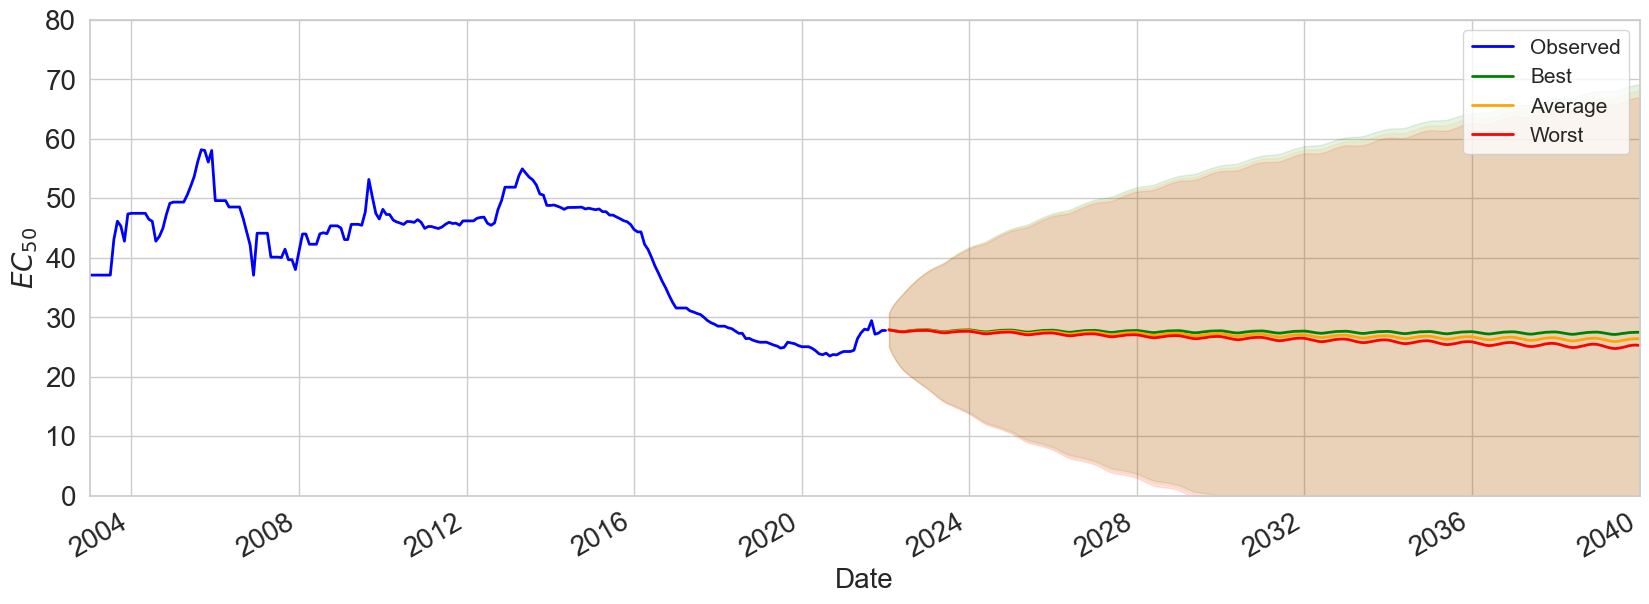

In [61]:

###BAD
bad = model.forecast(horizon, level=(80, 95), X_df=scenario_bad.set_index('unique_id'))
good= model.forecast(horizon, level=(80, 95), X_df=scenario_good.set_index('unique_id'))
mean = model.forecast(horizon, level=(80, 95), X_df=scenario_mean.set_index('unique_id'))

plot_with_int_all(good, "Best",mean, "Average",bad, "Worst", "EC50", "$EC_{50}$","Observed")